In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib import rc

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import sys
import math
import pickle


import itertools



In [3]:

#FUNCTION
def partition_N(n):
    '''do the partition of a complete graph'''
    indexs = range(n)
    pairs_all = []

    swap_even = [i + pow(-1, i) for i in range(n)]

    swap_odd = [0]
    swap_odd.extend([i + pow(-1, i+1) for i in range(1,n-1)])
    swap_odd.append(n-1)

    pairs_even = [(i, i+1) for i in range(0, n, 2)]
    indexs = np.array(indexs)[swap_even]   ### indexs after swap even
    #     print('\nindexs after swap {}: {}'.format(0, indexs))
    pairs_all.append(pairs_even)
    for i in range(1, n):
        if (i%2)==1:
            pair_odd = [(indexs[i], indexs[i+1]) for i in range(1, n-1, 2)]
            pairs_all.append(pair_odd)
            indexs = np.array(indexs)[swap_odd]   ### indexs after swap even
    #             print('\nindexs after swap {}: {}'.format(i, indexs))

        elif (i%2)==0:
            pair_even = [(indexs[i], indexs[i+1]) for i in range(0, n-1, 2)]
            pairs_all.append(pair_even)
            indexs = np.array(indexs)[swap_even]   ### indexs after swap even
    #             print('\nindexs after swap {}: {}'.format(i, indexs))

    return pairs_all

def partition_graph(G):
    """
    Partition the edges of a given graph.
    G: Input graph (not necessarily complete)
    Returns: List of edge partitions
    """
    edges = list(G.edges())  # Get the edges of the graph
    n = G.number_of_nodes()  # Number of nodes in the graph
    pairs_all = []

    # Swapping indices for even and odd iterations
    swap_even = [i + pow(-1, i) for i in range(n)]
    swap_odd = [0]
    swap_odd.extend([i + pow(-1, i + 1) for i in range(1, n - 1)])
    swap_odd.append(n - 1)

    # Initial indices and first partition
    indexs = list(range(n))
    pairs_even = [(i, i + 1) for i in range(0, n, 2) if (i, i + 1) in edges or (i + 1, i) in edges]
    indexs = np.array(indexs)[swap_even]  # Apply initial swap
    pairs_all.append(pairs_even)

    # Iterate to create partitions
    for i in range(1, n):
        if i % 2 == 1:
            pair_odd = [(indexs[j], indexs[j + 1]) for j in range(1, n - 1, 2)
                        if (indexs[j], indexs[j + 1]) in edges or (indexs[j + 1], indexs[j]) in edges]
            pairs_all.append(pair_odd)
            indexs = np.array(indexs)[swap_odd]  # Swap for odd iteration
        else:
            pair_even = [(indexs[j], indexs[j + 1]) for j in range(0, n - 1, 2)
                         if (indexs[j], indexs[j + 1]) in edges or (indexs[j + 1], indexs[j]) in edges]
            pairs_all.append(pair_even)
            indexs = np.array(indexs)[swap_even]  # Swap for even iteration

    return pairs_all


In [4]:
def compute_cvar(probabilities, values, alpha):
    """
    Auxilliary method to compute the conditional value at risk.

    Args:
        probabilities (List[Real]): The probabilities for measuring a bit string
        values (List[Real]): The corresponding energy values
        alpha (Real): Confidence level for the conditional value at risk

    Returns:
        cvar (Real): The conditional value at risk
    """
    
    sorted_indices = np.argsort(values)
    probs = np.array(probabilities)[sorted_indices]
    vals = np.array(values)[sorted_indices]

    cvar = 0
    total_prob = 0
    for i, (p, v) in enumerate(zip(probs, vals)):
        if p >= alpha - total_prob:
            p = alpha - total_prob
        total_prob += p
        cvar += p * v
        if abs(total_prob - alpha) < 1e-8:
            break

    cvar /= total_prob

    return cvar

# Iterative Adap various graphs


tau =  0.3 alpha =  0.01 qubits =  14 parameters = 56

tau =  0.3 alpha =  0.01 qubits =  16 parameters = 64

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 72

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 80

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 106

tau =  0.3 alpha =  0.01 qubits =  16 parameters = 136

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 170

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 210

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 142

tau =  0.3 alpha =  0.01 qubits =  16 parameters = 184

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 232

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 286

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 160

tau =  0.3 alpha =  0.01 qubits =  16 parameters = 208

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 262

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 324

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 178

tau =  0.3 alpha =  0.01 qubits =  16 parameters = 

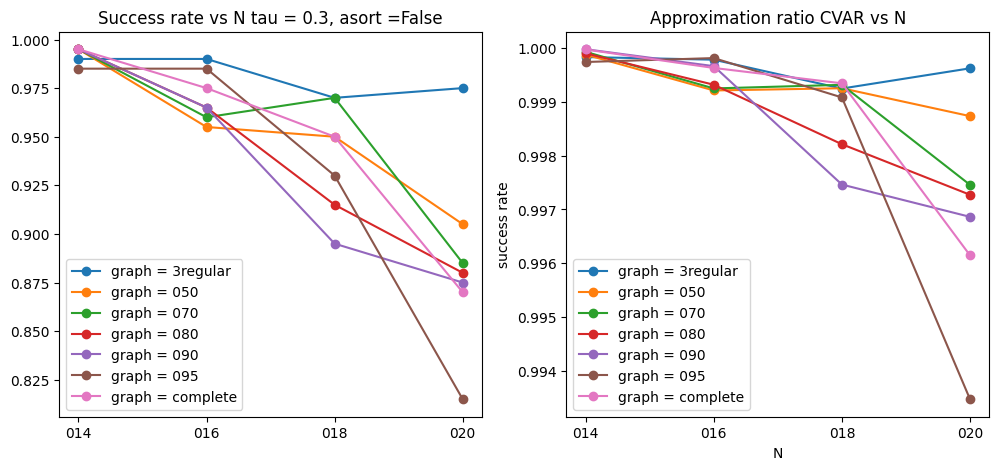

In [5]:
num_variables_list = [str(num).zfill(3) for num in range(14,22, 2)] 
graph_type_list = [ '3regular', '050', '070', '080', '090', '095','complete']

r_list = range(200)
tau_list =[0.3] # [0.3, 0.4]
alpha_list = [0.01]
layer = 1
shots = None
tot_steps = range(5)
if_adsorting = False

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

for graph in graph_type_list:

    dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                            .format(graph,  shots)
    
    sr_array = np.zeros((len(num_opt_list), len(num_variables_list)))
    ar_array = np.zeros(len(num_variables_list))

    for n_qubits_i, num_variables in enumerate(num_variables_list):
        n_qubits = int(num_variables)

        N = n_qubits
        
        if graph == 'complete':
            # pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
            # num_pairs = len(pairs_all)
            # num_params = (n_qubits + 2*num_pairs) * layer
            # print(num_pairs, num_params)
            num_params = int(2*(N-1)*N/2 + N)
        elif graph == '3regular':
            num_params= int(2*(3*N)/2 + N)
        else:
            density = float(f"0.{int(graph)}")
            num_params = 2*round((N-1)*N*density/2) +N

        for alpha in alpha_list:

            for taui, tau in enumerate(tau_list):
                print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N, "parameters =", num_params)

                dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                    .format(num_variables, num_params, layer, alpha)
                
                for r in r_list:
                    # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
                    
                    file_dir_name = dir_name + '/r_{}'\
                                .format(r)
                    
                    filename = file_dir_name + '/ifadsorting_{}_tau_{}.pkl'\
                                                            .format(if_adsorting,tau)
                    with open(filename, 'rb') as f:
                        data = pickle.load(f)

                    params_list = data["params_list"]
                    if len(params_list) != round(num_params):
                        print("error N, r = ", r, len(params_list))
                        
                    steps_exp_poss_dict = data["steps_exp_poss_dict"]
                    steps_cvar_dict = data["steps_cvar_dict"]
                    steps_entropy_dict = data["steps_entropy_dict"]
                    
                    final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
                    poss_list = list(final_exp_poss.values())
                    if poss_list[0] > alpha:
                        sr_array[0, n_qubits_i] += 1/len(r_list)
                    if sum(poss_list[:2]) > alpha:
                        sr_array[1, n_qubits_i] += 1/len(r_list)
                    if sum(poss_list[:3]) > alpha:
                        sr_array[2, n_qubits_i] += 1/len(r_list)

                    exp_opt = list(final_exp_poss.keys())[0]
                    cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]
                    ar_array[n_qubits_i] += (cvar/exp_opt) / len(r_list)

    # print("sr_array = ", sr_array)
    ax1.plot(num_variables_list, sr_array[0], "o-", label=f"graph = {graph}")
    # ax1.plot(tau_list, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
    # ax1.plot(tau_list, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

    ax2.plot(num_variables_list, ar_array, "o-", label=f"graph = {graph}")
    # print("ar_array = ", ar_array)

    ax1.set_title(f'Success rate vs N tau = {tau}, asort ={if_adsorting}')
    ax2.set_title('Approximation ratio CVAR vs N')

    ax1.legend()
plt.legend()
plt.xlabel("N")
plt.ylabel("success rate")
plt.show()



In [14]:
num_variables_list = [str(num).zfill(3) for num in range(20,22, 2)] 
graph_type_list = [ '3regular', '050', '070', '080', '090', '095','complete']

for graph in graph_type_list:

    for n_qubits_i, num_variables in enumerate(num_variables_list):
        n_qubits = int(num_variables)

        N = n_qubits
        
        if graph == 'complete':
            # pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
            # num_pairs = len(pairs_all)
            # num_params = (n_qubits + 2*num_pairs) * layer
            # print(num_pairs, num_params)
            num_params = int(2*(N-1)*N/2 + N)
            edges = (N-1)*N/2
        elif graph == '3regular':
            num_params= int(2*(3*N)/2 + N)
            edges = int((3*N)/2 )
        else:
            density = float(f"0.{int(graph)}")
            num_params = 2*round((N-1)*N*density/2) +N
            edges = round((N-1)*N*density/2) 

        print('n_qubits', n_qubits, 'graph', graph, 'edges', edges)

n_qubits 20 graph 3regular edges 30
n_qubits 20 graph 050 edges 95
n_qubits 20 graph 070 edges 133
n_qubits 20 graph 080 edges 152
n_qubits 20 graph 090 edges 171
n_qubits 20 graph 095 edges 180
n_qubits 20 graph complete edges 190.0



tau =  0.3 alpha =  0.01 qubits =  14 parameters = 56

tau =  0.3 alpha =  0.01 qubits =  16 parameters = 64

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 72

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 80

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 106

tau =  0.3 alpha =  0.01 qubits =  16 parameters = 136

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 170

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 210

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 142

tau =  0.3 alpha =  0.01 qubits =  16 parameters = 184

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 232

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 286

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 160

tau =  0.3 alpha =  0.01 qubits =  16 parameters = 208

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 262

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 324

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 178

tau =  0.3 alpha =  0.01 qubits =  16 parameters = 

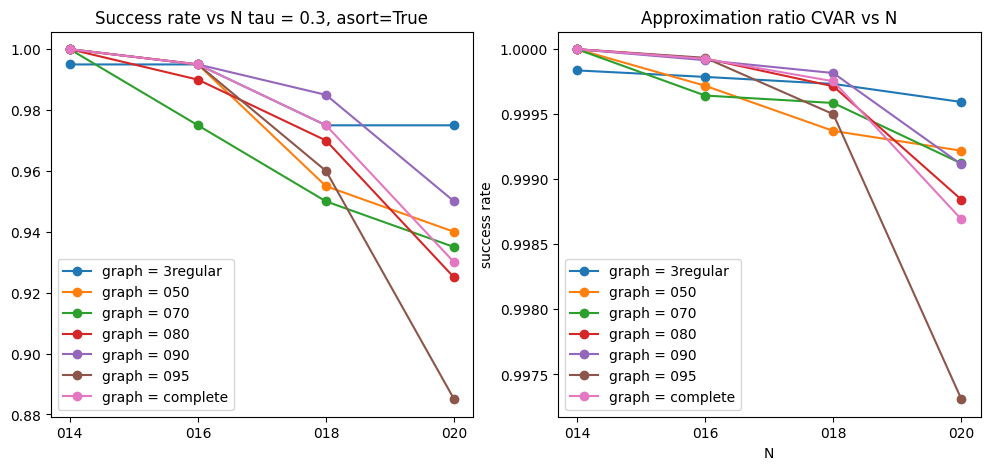

In [7]:
num_variables_list = [str(num).zfill(3) for num in range(14,22, 2)] 
graph_type_list = [ '3regular', '050', '070', '080', '090', '095','complete']

r_list = range(200)
tau_list =[0.3] # [0.3, 0.4]
alpha_list = [0.01]
layer = 1
shots = None
tot_steps = range(5)
if_adsorting = True

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

for graph in graph_type_list:

    dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                            .format(graph,  shots)
    
    sr_array = np.zeros((len(num_opt_list), len(num_variables_list)))
    ar_array = np.zeros(len(num_variables_list))

    for n_qubits_i, num_variables in enumerate(num_variables_list):
        n_qubits = int(num_variables)

        N = n_qubits
        
        if graph == 'complete':
            # pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
            # num_pairs = len(pairs_all)
            # num_params = (n_qubits + 2*num_pairs) * layer
            # print(num_pairs, num_params)
            num_params = int(2*(N-1)*N/2 + N)
        elif graph == '3regular':
            num_params= int(2*(3*N)/2 + N)
        else:
            density = float(f"0.{int(graph)}")
            num_params = 2*round((N-1)*N*density/2) +N

        for alpha in alpha_list:

            for taui, tau in enumerate(tau_list):
                print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N, "parameters =", num_params)

                dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                    .format(num_variables, num_params, layer, alpha)
                
                for r in r_list:
                    # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
                    
                    file_dir_name = dir_name + '/r_{}'\
                                .format(r)
                    
                    filename = file_dir_name + '/ifadsorting_{}_tau_{}.pkl'\
                                                            .format(if_adsorting,tau)
                    with open(filename, 'rb') as f:
                        data = pickle.load(f)

                    params_list = data["params_list"]
                    if len(params_list) != round(num_params):
                        print("error N, r = ", r, len(params_list))
                        
                    steps_exp_poss_dict = data["steps_exp_poss_dict"]
                    steps_cvar_dict = data["steps_cvar_dict"]
                    steps_entropy_dict = data["steps_entropy_dict"]
                    
                    final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
                    poss_list = list(final_exp_poss.values())
                    if poss_list[0] > alpha:
                        sr_array[0, n_qubits_i] += 1/len(r_list)
                    if sum(poss_list[:2]) > alpha:
                        sr_array[1, n_qubits_i] += 1/len(r_list)
                    if sum(poss_list[:3]) > alpha:
                        sr_array[2, n_qubits_i] += 1/len(r_list)

                    exp_opt = list(final_exp_poss.keys())[0]
                    cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]
                    ar_array[n_qubits_i] += (cvar/exp_opt) / len(r_list)

    # print("sr_array = ", sr_array)
    ax1.plot(num_variables_list, sr_array[0], "o-", label=f"graph = {graph}")
    # ax1.plot(tau_list, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
    # ax1.plot(tau_list, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

    ax2.plot(num_variables_list, ar_array, "o-", label=f"graph = {graph}")
    # print("ar_array = ", ar_array)

    ax1.set_title(f'Success rate vs N tau = {tau}, asort={if_adsorting}')
    ax2.set_title('Approximation ratio CVAR vs N')

    ax1.legend()
plt.legend()
plt.xlabel("N")
plt.ylabel("success rate")
plt.show()


tau =  0.4 alpha =  0.01 qubits =  14 parameters = 56

tau =  0.4 alpha =  0.01 qubits =  16 parameters = 64

tau =  0.4 alpha =  0.01 qubits =  18 parameters = 72

tau =  0.4 alpha =  0.01 qubits =  20 parameters = 80

tau =  0.4 alpha =  0.01 qubits =  14 parameters = 106

tau =  0.4 alpha =  0.01 qubits =  16 parameters = 136

tau =  0.4 alpha =  0.01 qubits =  18 parameters = 170

tau =  0.4 alpha =  0.01 qubits =  20 parameters = 210

tau =  0.4 alpha =  0.01 qubits =  14 parameters = 142

tau =  0.4 alpha =  0.01 qubits =  16 parameters = 184

tau =  0.4 alpha =  0.01 qubits =  18 parameters = 232

tau =  0.4 alpha =  0.01 qubits =  20 parameters = 286

tau =  0.4 alpha =  0.01 qubits =  14 parameters = 160

tau =  0.4 alpha =  0.01 qubits =  16 parameters = 208

tau =  0.4 alpha =  0.01 qubits =  18 parameters = 262

tau =  0.4 alpha =  0.01 qubits =  20 parameters = 324

tau =  0.4 alpha =  0.01 qubits =  14 parameters = 178

tau =  0.4 alpha =  0.01 qubits =  16 parameters = 

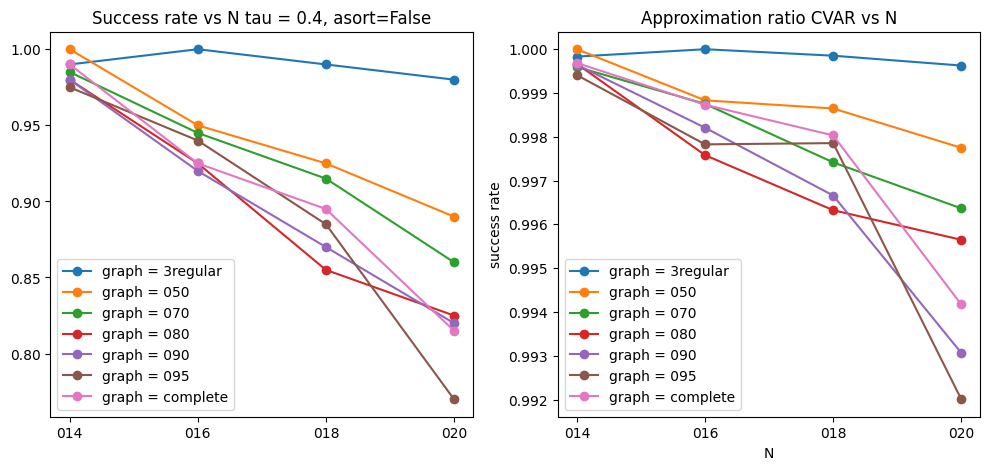

In [8]:
num_variables_list = [str(num).zfill(3) for num in range(14,22, 2)] 
graph_type_list = [ '3regular', '050', '070', '080', '090', '095','complete']

r_list = range(200)
tau_list =[0.4] # [0.3, 0.4]
alpha_list = [0.01]
layer = 1
shots = None
tot_steps = range(5)
if_adsorting = False

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

for graph in graph_type_list:

    dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                            .format(graph,  shots)
    
    sr_array = np.zeros((len(num_opt_list), len(num_variables_list)))
    ar_array = np.zeros(len(num_variables_list))

    for n_qubits_i, num_variables in enumerate(num_variables_list):
        n_qubits = int(num_variables)

        N = n_qubits
        
        if graph == 'complete':
            # pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
            # num_pairs = len(pairs_all)
            # num_params = (n_qubits + 2*num_pairs) * layer
            # print(num_pairs, num_params)
            num_params = int(2*(N-1)*N/2 + N)
        elif graph == '3regular':
            num_params= int(2*(3*N)/2 + N)
        else:
            density = float(f"0.{int(graph)}")
            num_params = 2*round((N-1)*N*density/2) +N

        for alpha in alpha_list:

            for taui, tau in enumerate(tau_list):
                print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N, "parameters =", num_params)

                dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                    .format(num_variables, num_params, layer, alpha)
                
                for r in r_list:
                    # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
                    
                    file_dir_name = dir_name + '/r_{}'\
                                .format(r)
                    
                    filename = file_dir_name + '/ifadsorting_{}_tau_{}.pkl'\
                                                            .format(if_adsorting,tau)
                    with open(filename, 'rb') as f:
                        data = pickle.load(f)

                    params_list = data["params_list"]
                    if len(params_list) != round(num_params):
                        print("error N, r = ", r, len(params_list))
                        
                    steps_exp_poss_dict = data["steps_exp_poss_dict"]
                    steps_cvar_dict = data["steps_cvar_dict"]
                    steps_entropy_dict = data["steps_entropy_dict"]
                    
                    final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
                    poss_list = list(final_exp_poss.values())
                    if poss_list[0] > alpha:
                        sr_array[0, n_qubits_i] += 1/len(r_list)
                    if sum(poss_list[:2]) > alpha:
                        sr_array[1, n_qubits_i] += 1/len(r_list)
                    if sum(poss_list[:3]) > alpha:
                        sr_array[2, n_qubits_i] += 1/len(r_list)

                    exp_opt = list(final_exp_poss.keys())[0]
                    cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]
                    ar_array[n_qubits_i] += (cvar/exp_opt) / len(r_list)

    # print("sr_array = ", sr_array)
    ax1.plot(num_variables_list, sr_array[0], "o-", label=f"graph = {graph}")
    # ax1.plot(tau_list, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
    # ax1.plot(tau_list, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

    ax2.plot(num_variables_list, ar_array, "o-", label=f"graph = {graph}")
    # print("ar_array = ", ar_array)

    ax1.set_title(f'Success rate vs N tau = {tau}, asort={if_adsorting}')
    ax2.set_title('Approximation ratio CVAR vs N')

    ax1.legend()
plt.legend()
plt.xlabel("N")
plt.ylabel("success rate")
plt.show()



tau =  0.4 alpha =  0.01 qubits =  14 parameters = 56

tau =  0.4 alpha =  0.01 qubits =  16 parameters = 64

tau =  0.4 alpha =  0.01 qubits =  18 parameters = 72

tau =  0.4 alpha =  0.01 qubits =  20 parameters = 80

tau =  0.4 alpha =  0.01 qubits =  14 parameters = 106

tau =  0.4 alpha =  0.01 qubits =  16 parameters = 136

tau =  0.4 alpha =  0.01 qubits =  18 parameters = 170

tau =  0.4 alpha =  0.01 qubits =  20 parameters = 210

tau =  0.4 alpha =  0.01 qubits =  14 parameters = 142

tau =  0.4 alpha =  0.01 qubits =  16 parameters = 184

tau =  0.4 alpha =  0.01 qubits =  18 parameters = 232

tau =  0.4 alpha =  0.01 qubits =  20 parameters = 286

tau =  0.4 alpha =  0.01 qubits =  14 parameters = 160

tau =  0.4 alpha =  0.01 qubits =  16 parameters = 208

tau =  0.4 alpha =  0.01 qubits =  18 parameters = 262

tau =  0.4 alpha =  0.01 qubits =  20 parameters = 324

tau =  0.4 alpha =  0.01 qubits =  14 parameters = 178

tau =  0.4 alpha =  0.01 qubits =  16 parameters = 

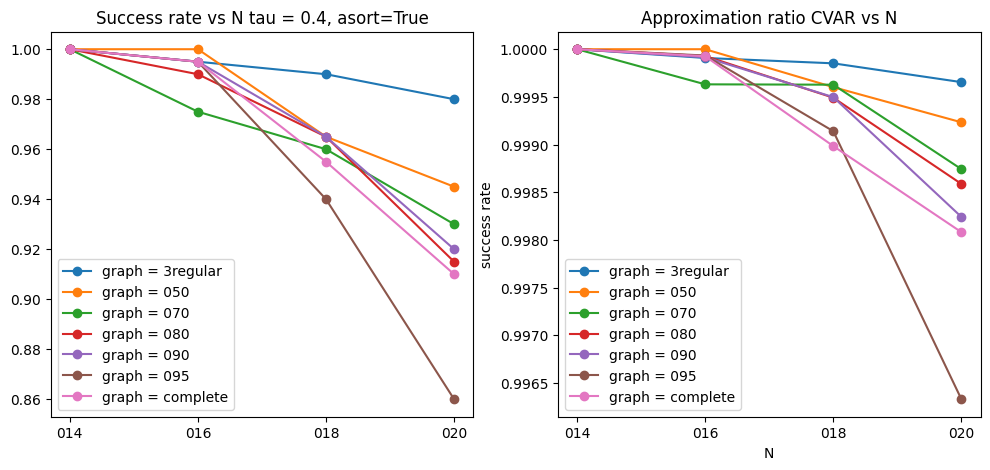

In [9]:
num_variables_list = [str(num).zfill(3) for num in range(14,22, 2)] 
graph_type_list = [ '3regular', '050', '070', '080', '090', '095','complete']

r_list = range(200)
tau_list =[0.4] # [0.3, 0.4]
alpha_list = [0.01]
layer = 1
shots = None
tot_steps = range(5)
if_adsorting = True

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

for graph in graph_type_list:

    dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                            .format(graph,  shots)
    
    sr_array = np.zeros((len(num_opt_list), len(num_variables_list)))
    ar_array = np.zeros(len(num_variables_list))

    for n_qubits_i, num_variables in enumerate(num_variables_list):
        n_qubits = int(num_variables)

        N = n_qubits
        
        if graph == 'complete':
            # pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
            # num_pairs = len(pairs_all)
            # num_params = (n_qubits + 2*num_pairs) * layer
            # print(num_pairs, num_params)
            num_params = int(2*(N-1)*N/2 + N)
        elif graph == '3regular':
            num_params= int(2*(3*N)/2 + N)
        else:
            density = float(f"0.{int(graph)}")
            num_params = 2*round((N-1)*N*density/2) +N

        for alpha in alpha_list:

            for taui, tau in enumerate(tau_list):
                print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N, "parameters =", num_params)

                dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                    .format(num_variables, num_params, layer, alpha)
                
                for r in r_list:
                    # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
                    
                    file_dir_name = dir_name + '/r_{}'\
                                .format(r)
                    
                    filename = file_dir_name + '/ifadsorting_{}_tau_{}.pkl'\
                                                            .format(if_adsorting,tau)
                    with open(filename, 'rb') as f:
                        data = pickle.load(f)

                    params_list = data["params_list"]
                    if len(params_list) != round(num_params):
                        print("error N, r = ", r, len(params_list))
                        
                    steps_exp_poss_dict = data["steps_exp_poss_dict"]
                    steps_cvar_dict = data["steps_cvar_dict"]
                    steps_entropy_dict = data["steps_entropy_dict"]
                    
                    final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
                    poss_list = list(final_exp_poss.values())
                    if poss_list[0] > alpha:
                        sr_array[0, n_qubits_i] += 1/len(r_list)
                    if sum(poss_list[:2]) > alpha:
                        sr_array[1, n_qubits_i] += 1/len(r_list)
                    if sum(poss_list[:3]) > alpha:
                        sr_array[2, n_qubits_i] += 1/len(r_list)

                    exp_opt = list(final_exp_poss.keys())[0]
                    cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]
                    ar_array[n_qubits_i] += (cvar/exp_opt) / len(r_list)

    # print("sr_array = ", sr_array)
    ax1.plot(num_variables_list, sr_array[0], "o-", label=f"graph = {graph}")
    # ax1.plot(tau_list, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
    # ax1.plot(tau_list, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

    ax2.plot(num_variables_list, ar_array, "o-", label=f"graph = {graph}")
    # print("ar_array = ", ar_array)

    ax1.set_title(f'Success rate vs N tau = {tau}, asort={if_adsorting}')
    ax2.set_title('Approximation ratio CVAR vs N')

    ax1.legend()
plt.legend()
plt.xlabel("N")
plt.ylabel("success rate")
plt.show()


tau =  0.3 alpha =  0.01 qubits =  20 parameters = 400

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 80

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 210

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 286

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 324

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 362

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 380

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 400

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 80

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 210

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 286

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 324

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 362

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 380

tau =  0.4 alpha =  0.01 qubits =  20 parameters = 400

tau =  0.4 alpha =  0.01 qubits =  20 parameters = 80

tau =  0.4 alpha =  0.01 qubits =  20 parameters = 210

tau =  0.4 alpha =  0.01 qubits =  20 parameters =

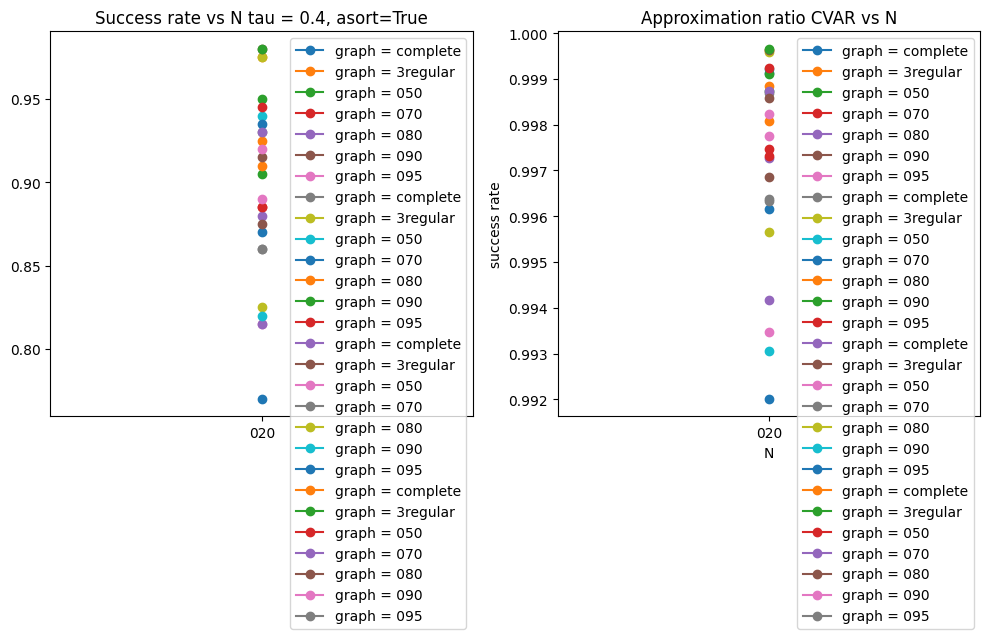

In [10]:
num_variables_list = [str(num).zfill(3) for num in range(20,22, 2)] 
graph_type_list = ['complete', '3regular', '050', '070', '080', '090', '095']

r_list = range(200)
tau_list = [0.3, 0.4]
alpha_list = [0.01]
layer = 1
shots = None
tot_steps = range(5)
if_adsorting_list = [False,True]

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]

f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

for taui, tau in enumerate(tau_list):
     
    for if_adsorting in if_adsorting_list:

        ssr = []
        sar = []

        for graph in graph_type_list:
            
            sr_array = np.zeros((len(num_opt_list), len(num_variables_list)))
            ar_array = np.zeros(len(num_variables_list))

            for n_qubits_i, num_variables in enumerate(num_variables_list):
                n_qubits = int(num_variables)

                N = n_qubits

                dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                            .format(graph,  shots)
                
                if graph == 'complete':
                    num_params = int(2*(N-1)*N/2 + N)
                elif graph == '3regular':
                    num_params= int(2*(3*N)/2 + N)
                else:
                    density = float(f"0.{int(graph)}")
                    num_params = 2*round((N-1)*N*density/2) +N

                for alpha in alpha_list:

                    print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N, "parameters =", num_params)

                    dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                        .format(num_variables, num_params, layer, alpha)
                    
                    for r in r_list:
                        
                        file_dir_name = dir_name + '/r_{}'\
                                    .format(r)
                        
                        filename = file_dir_name + '/ifadsorting_{}_tau_{}.pkl'\
                                                                .format(if_adsorting,tau)
                        with open(filename, 'rb') as f:
                            data = pickle.load(f)

                        params_list = data["params_list"]
                        if len(params_list) != round(num_params):
                            print("error N, r = ", r, len(params_list))
                            
                        steps_exp_poss_dict = data["steps_exp_poss_dict"]
                        steps_cvar_dict = data["steps_cvar_dict"]
                        steps_entropy_dict = data["steps_entropy_dict"]
                        
                        final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
                        poss_list = list(final_exp_poss.values())
                        if poss_list[0] > alpha:
                            sr_array[0, n_qubits_i] += 1/len(r_list)
                        if sum(poss_list[:2]) > alpha:
                            sr_array[1, n_qubits_i] += 1/len(r_list)
                        if sum(poss_list[:3]) > alpha:
                            sr_array[2, n_qubits_i] += 1/len(r_list)

                        exp_opt = list(final_exp_poss.keys())[0]
                        cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]
                        ar_array[n_qubits_i] += (cvar/exp_opt) / len(r_list)

            # print("sr_array = ", sr_array)
            ax1.plot(num_variables_list, sr_array[0], "o-", label=f"graph = {graph}")
            # ax1.plot(tau_list, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
            # ax1.plot(tau_list, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

            ax2.plot(num_variables_list, ar_array, "o-", label=f"graph = {graph}")
            # print("ar_array = ", ar_array)

            ax1.set_title(f'Success rate vs N tau = {tau}, asort={if_adsorting}')
            ax2.set_title('Approximation ratio CVAR vs N')

            ax1.legend()
        
        # ssr.append(sr)
        # sar.append(ar)
    
plt.legend()
plt.xlabel("N")
plt.ylabel("success rate")
plt.show()

ITE ADAP STEPS


 step =  0 tau =  0.4 alpha =  0.01 N = 20

 step =  1 tau =  0.4 alpha =  0.01 N = 20

 step =  2 tau =  0.4 alpha =  0.01 N = 20

 step =  3 tau =  0.4 alpha =  0.01 N = 20

 step =  4 tau =  0.4 alpha =  0.01 N = 20
sr_array =  [[0.025 0.94  0.975 0.98  0.98 ]
 [0.05  0.965 0.975 0.98  0.98 ]
 [0.    0.    0.    0.    0.   ]]
ar_array =  [[0.976469   0.9995842  0.99965368 0.99962925 0.99962715]
 [0.98182668 0.99968444 0.99968227 0.99965624 0.99965479]
 [0.         0.         0.         0.         0.        ]]

 step =  0 tau =  0.4 alpha =  0.01 N = 20

 step =  1 tau =  0.4 alpha =  0.01 N = 20

 step =  2 tau =  0.4 alpha =  0.01 N = 20

 step =  3 tau =  0.4 alpha =  0.01 N = 20

 step =  4 tau =  0.4 alpha =  0.01 N = 20
sr_array =  [[0.1   0.835 0.87  0.885 0.89 ]
 [0.275 0.925 0.935 0.945 0.945]
 [0.    0.    0.    0.    0.   ]]
ar_array =  [[0.98215586 0.99664354 0.99705001 0.99767504 0.99774936]
 [0.99116296 0.99886874 0.9990631  0.99923899 0.99923355]
 [0.         0.      

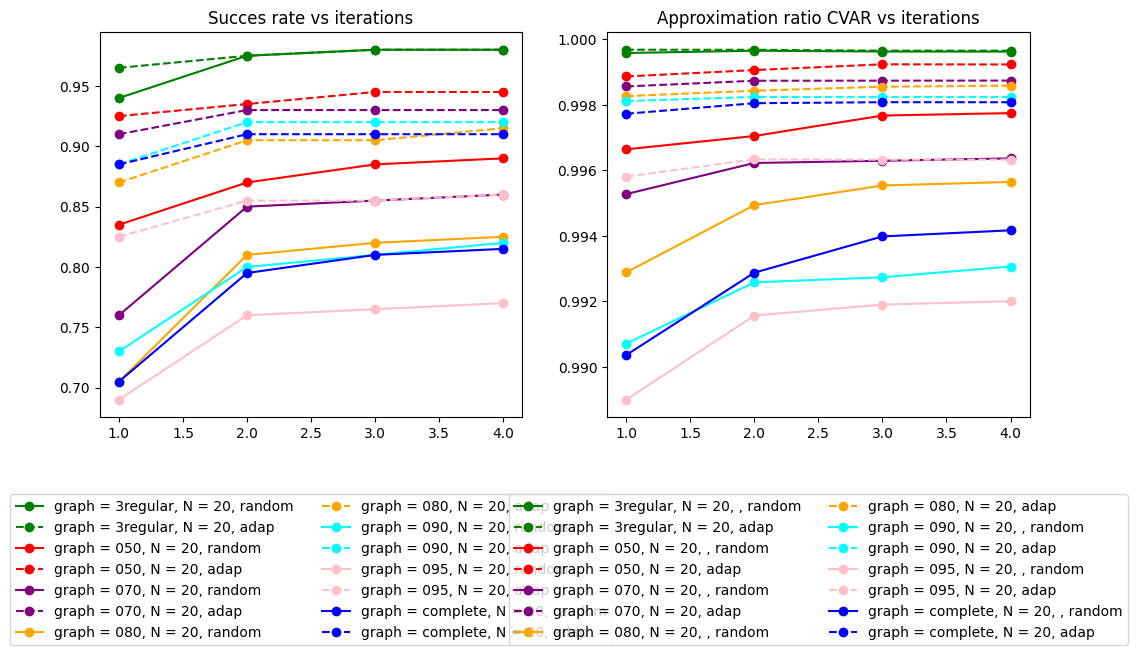

<Figure size 1200x800 with 0 Axes>

In [11]:
num_variables_list = [str(num).zfill(3) for num in range(20,22, 2)] 
graph_type_list = ['3regular', '050', '070', '080', '090', '095', 'complete']
# graph_type_list = ['3regular', '050', '070', '080', '090', 'complete']

r_list = range(200)
tau_list = [0.3, 0.4]
alpha_list = [0.01]
layer = 1
shots = None
tot_steps = range(5)
if_adsorting_list = [False,True]

tot_steps = range(5)

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]

f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

color_map = {
    "complete": "blue",
    "3regular": "green",
    "050": "red",
    "070": "purple",
    "080": "orange",
    "090": "cyan",
    "095": "pink",
}

tau = 0.4
dir_0_adap =  './data_iter_adap_sorting' 

# for graph in graph_type_list: 
#     for num_variables in num_variables_list:
for num_variables in num_variables_list:
    for graph in graph_type_list: 
        
        tot_steps = range(5) 

        sr_array = np.zeros((len(num_opt_list), len(tot_steps)))
        ar_array = np.zeros((len(num_opt_list), len(tot_steps)))


        n_qubits = int(num_variables)

        N = n_qubits
        
        dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                    .format(graph,  shots)
        
        if graph == 'complete':
            num_params = int(2*(N-1)*N/2 + N)
        elif graph == '3regular':
            num_params= int(2*(3*N)/2 + N)
        else:
            density = float(f"0.{int(graph)}")
            num_params = 2*round((N-1)*N*density/2) +N

        for step in tot_steps:
            print("\n step = ", step, "tau = ", tau, "alpha = ", alpha, "N =", N)
            
            dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                            .format(num_variables, num_params, layer, alpha)
            
            for r in r_list:
                # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"

                file_dir_name = dir_name + '/r_{}'\
                                    .format(r)
                
                filename = file_dir_name + '/ifadsorting_{}_tau_{}.pkl'\
                                            .format(False,tau)
                                
                with open(filename, 'rb') as f:
                    data = pickle.load(f)

                filename_adap =  file_dir_name + '/ifadsorting_{}_tau_{}.pkl'\
                                            .format(True,tau)
                                
                with open(filename_adap, 'rb') as f:
                    data_adap = pickle.load(f)

                params_list = data["params_list"]

                params_list = data_adap["params_list"]

                steps_exp_poss_dict = data["steps_exp_poss_dict"]
                steps_cvar_dict = data["steps_cvar_dict"]
                final_exp_poss = steps_exp_poss_dict[f"step_{step}"]["l_1"]  
                poss_list = list(final_exp_poss.values())

                steps_exp_poss_dict_adap = data_adap["steps_exp_poss_dict"]
                steps_cvar_dict_adap = data_adap["steps_cvar_dict"]
                final_exp_poss_adap = steps_exp_poss_dict_adap[f"step_{step}"]["l_1"]
                poss_list_adap = list(final_exp_poss_adap.values())


                if poss_list[0] > alpha:
                    sr_array[0, step] += 1/len(r_list)
                if poss_list_adap[0] > alpha:
                    sr_array[1, step] += 1/len(r_list)

                # if sum(poss_list[:3]) > alpha:
                #     sr_array[2, step] += 1/len(r_list)

                exp_opt = list(final_exp_poss.keys())[0]
                cvar = steps_cvar_dict[f"step_{step}"]

                ar_array[0,step] += (cvar/exp_opt) / len(r_list)

                exp_opt = list(final_exp_poss_adap.keys())[0]
                cvar = steps_cvar_dict_adap[f"step_{step}"]

                ar_array[1,step] += (cvar/exp_opt) / len(r_list)

        tot_steps = range(1,5)
        
        color = color_map.get(graph, "black")

        print("sr_array = ", sr_array)
        ax1.plot(tot_steps, sr_array[0][1:], "o-", color=color, label=f"graph = {graph}, N = {N}, random")
        ax1.plot(tot_steps, sr_array[1][1:], "o--",color=color, label=f"graph = {graph}, N = {N}, adap")
        # ax1.plot(tot_steps, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

        ax2.plot(tot_steps, ar_array[0][1:], "o-", color=color, label=f"graph = {graph}, N = {N}, , random")
        ax2.plot(tot_steps, ar_array[1][1:], "o--", color=color, label=f"graph = {graph}, N = {N}, adap")

        ax1.set_title('Succes rate vs iterations')
        ax2.set_title('Approximation ratio CVAR vs iterations')

        ax1.legend()
        print("ar_array = ", ar_array)
# plt.legend()
f = plt.figure(figsize=(12, 8))
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2, borderaxespad=0.)
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2, borderaxespad=0.)
plt.tight_layout()
# plt.xlabel("iterations")
# plt.ylabel("success rate")
plt.show()


 step =  0 tau =  0.3 alpha =  0.01 N = 20

 step =  1 tau =  0.3 alpha =  0.01 N = 20

 step =  2 tau =  0.3 alpha =  0.01 N = 20

 step =  3 tau =  0.3 alpha =  0.01 N = 20

 step =  4 tau =  0.3 alpha =  0.01 N = 20
sr_array =  [[0.    0.92  0.965 0.975 0.975]
 [0.    0.925 0.965 0.975 0.975]
 [0.    0.    0.    0.    0.   ]]
ar_array =  [[0.94567031 0.99926869 0.99960025 0.99962263 0.99962252]
 [0.94986244 0.99934018 0.99950763 0.99959445 0.99959434]
 [0.         0.         0.         0.         0.        ]]

 step =  0 tau =  0.3 alpha =  0.01 N = 20

 step =  1 tau =  0.3 alpha =  0.01 N = 20

 step =  2 tau =  0.3 alpha =  0.01 N = 20

 step =  3 tau =  0.3 alpha =  0.01 N = 20

 step =  4 tau =  0.3 alpha =  0.01 N = 20
sr_array =  [[0.025 0.81  0.885 0.905 0.905]
 [0.07  0.9   0.935 0.94  0.94 ]
 [0.    0.    0.    0.    0.   ]]
ar_array =  [[0.97395023 0.99709256 0.9984016  0.99873457 0.99873441]
 [0.98187231 0.99860018 0.99906228 0.99921976 0.99921976]
 [0.         0.      

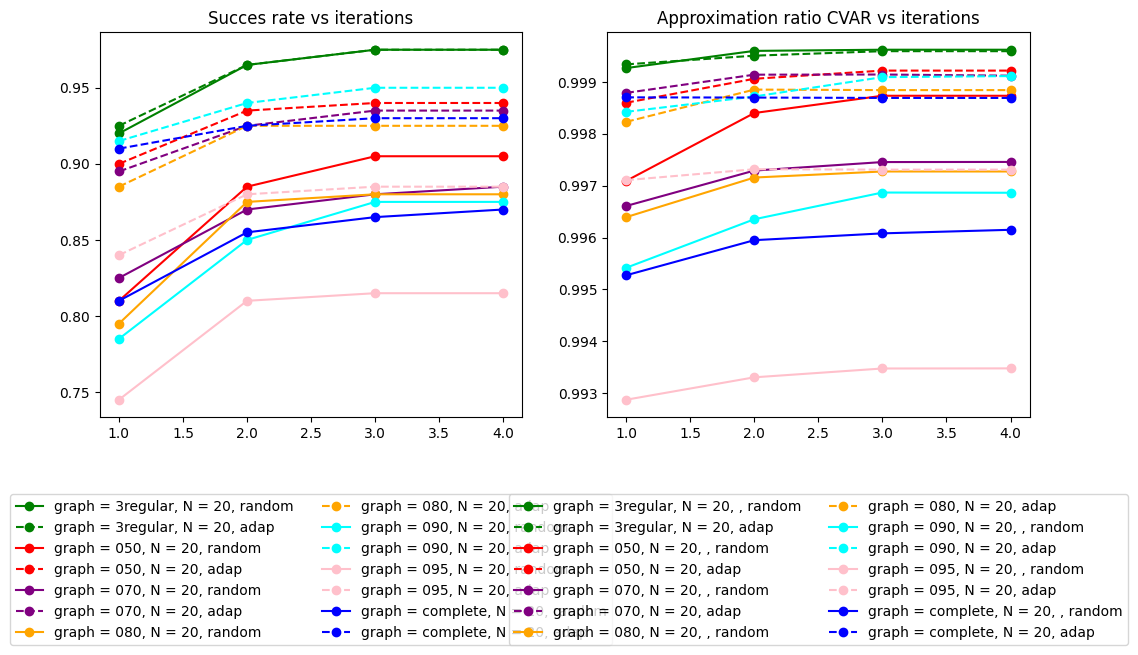

<Figure size 1200x800 with 0 Axes>

In [12]:
num_variables_list = [str(num).zfill(3) for num in range(20,22, 2)] 
graph_type_list = ['3regular', '050', '070', '080', '090', '095', 'complete']
# graph_type_list = ['3regular', '050', '070', '080', '090', 'complete']

r_list = range(200)
tau_list = [0.3, 0.4]
alpha_list = [0.01]
layer = 1
shots = None
tot_steps = range(5)
if_adsorting_list = [False,True]

tot_steps = range(5)

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]

f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

color_map = {
    "complete": "blue",
    "3regular": "green",
    "050": "red",
    "070": "purple",
    "080": "orange",
    "090": "cyan",
    "095": "pink",
}

tau = 0.3
dir_0_adap =  './data_iter_adap_sorting' 

# for graph in graph_type_list: 
#     for num_variables in num_variables_list:
for num_variables in num_variables_list:
    for graph in graph_type_list: 
        
        tot_steps = range(5) 

        sr_array = np.zeros((len(num_opt_list), len(tot_steps)))
        ar_array = np.zeros((len(num_opt_list), len(tot_steps)))


        n_qubits = int(num_variables)

        N = n_qubits
        
        dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                    .format(graph,  shots)
        
        if graph == 'complete':
            num_params = int(2*(N-1)*N/2 + N)
        elif graph == '3regular':
            num_params= int(2*(3*N)/2 + N)
        else:
            density = float(f"0.{int(graph)}")
            num_params = 2*round((N-1)*N*density/2) +N

        for step in tot_steps:
            print("\n step = ", step, "tau = ", tau, "alpha = ", alpha, "N =", N)
            
            dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                            .format(num_variables, num_params, layer, alpha)
            
            for r in r_list:
                # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"

                file_dir_name = dir_name + '/r_{}'\
                                    .format(r)
                
                filename = file_dir_name + '/ifadsorting_{}_tau_{}.pkl'\
                                            .format(False,tau)
                                
                with open(filename, 'rb') as f:
                    data = pickle.load(f)

                filename_adap =  file_dir_name + '/ifadsorting_{}_tau_{}.pkl'\
                                            .format(True,tau)
                                
                with open(filename_adap, 'rb') as f:
                    data_adap = pickle.load(f)

                params_list = data["params_list"]

                params_list = data_adap["params_list"]

                steps_exp_poss_dict = data["steps_exp_poss_dict"]
                steps_cvar_dict = data["steps_cvar_dict"]
                final_exp_poss = steps_exp_poss_dict[f"step_{step}"]["l_1"]  
                poss_list = list(final_exp_poss.values())

                steps_exp_poss_dict_adap = data_adap["steps_exp_poss_dict"]
                steps_cvar_dict_adap = data_adap["steps_cvar_dict"]
                final_exp_poss_adap = steps_exp_poss_dict_adap[f"step_{step}"]["l_1"]
                poss_list_adap = list(final_exp_poss_adap.values())


                if poss_list[0] > alpha:
                    sr_array[0, step] += 1/len(r_list)
                if poss_list_adap[0] > alpha:
                    sr_array[1, step] += 1/len(r_list)

                # if sum(poss_list[:3]) > alpha:
                #     sr_array[2, step] += 1/len(r_list)

                exp_opt = list(final_exp_poss.keys())[0]
                cvar = steps_cvar_dict[f"step_{step}"]

                ar_array[0,step] += (cvar/exp_opt) / len(r_list)

                exp_opt = list(final_exp_poss_adap.keys())[0]
                cvar = steps_cvar_dict_adap[f"step_{step}"]

                ar_array[1,step] += (cvar/exp_opt) / len(r_list)

        tot_steps = range(1,5)
        
        color = color_map.get(graph, "black")

        print("sr_array = ", sr_array)
        ax1.plot(tot_steps, sr_array[0][1:], "o-", color=color, label=f"graph = {graph}, N = {N}, random")
        ax1.plot(tot_steps, sr_array[1][1:], "o--",color=color, label=f"graph = {graph}, N = {N}, adap")
        # ax1.plot(tot_steps, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

        ax2.plot(tot_steps, ar_array[0][1:], "o-", color=color, label=f"graph = {graph}, N = {N}, , random")
        ax2.plot(tot_steps, ar_array[1][1:], "o--", color=color, label=f"graph = {graph}, N = {N}, adap")

        ax1.set_title('Succes rate vs iterations')
        ax2.set_title('Approximation ratio CVAR vs iterations')

        ax1.legend()
        print("ar_array = ", ar_array)
# plt.legend()
f = plt.figure(figsize=(12, 8))
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2, borderaxespad=0.)
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2, borderaxespad=0.)
plt.tight_layout()
# plt.xlabel("iterations")
# plt.ylabel("success rate")
plt.show()


 step =  0 tau =  0.3 alpha =  0.01 N = 20

 step =  1 tau =  0.3 alpha =  0.01 N = 20

 step =  2 tau =  0.3 alpha =  0.01 N = 20

 step =  3 tau =  0.3 alpha =  0.01 N = 20

 step =  4 tau =  0.3 alpha =  0.01 N = 20
sr_array =  [[0.    0.925 0.965 0.975 0.975]
 [0.05  0.965 0.975 0.98  0.98 ]
 [0.    0.    0.    0.    0.   ]]
ar_array =  [[0.94986244 0.99934018 0.99950763 0.99959445 0.99959434]
 [0.98182668 0.99968444 0.99968227 0.99965624 0.99965479]
 [0.         0.         0.         0.         0.        ]]

 step =  0 tau =  0.3 alpha =  0.01 N = 20

 step =  1 tau =  0.3 alpha =  0.01 N = 20

 step =  2 tau =  0.3 alpha =  0.01 N = 20

 step =  3 tau =  0.3 alpha =  0.01 N = 20

 step =  4 tau =  0.3 alpha =  0.01 N = 20
sr_array =  [[0.07  0.9   0.935 0.94  0.94 ]
 [0.275 0.925 0.935 0.945 0.945]
 [0.    0.    0.    0.    0.   ]]
ar_array =  [[0.98187231 0.99860018 0.99906228 0.99921976 0.99921976]
 [0.99116296 0.99886874 0.9990631  0.99923899 0.99923355]
 [0.         0.      

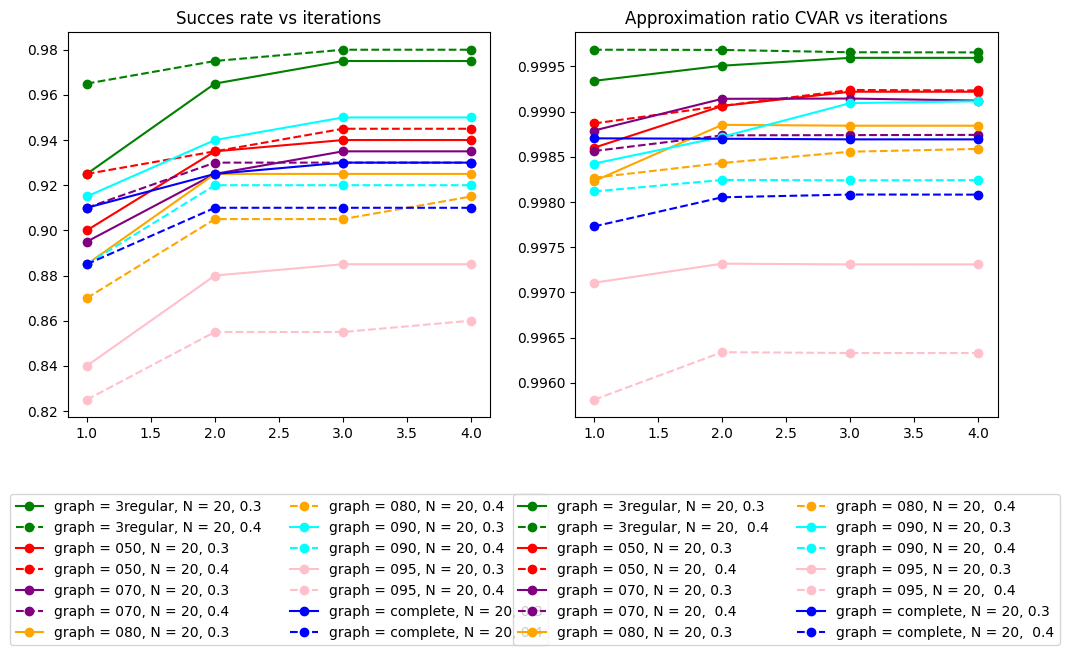

<Figure size 1200x800 with 0 Axes>

In [13]:
num_variables_list = [str(num).zfill(3) for num in range(20,22, 2)] 
graph_type_list = ['3regular', '050', '070', '080', '090', '095', 'complete']
# graph_type_list = ['3regular', '050', '070', '080', '090', 'complete']

r_list = range(200)
tau_list = [0.3, 0.4]
alpha_list = [0.01]
layer = 1
shots = None
tot_steps = range(5)
if_adsorting_list = [False,True]

tot_steps = range(5)

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]

f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

color_map = {
    "complete": "blue",
    "3regular": "green",
    "050": "red",
    "070": "purple",
    "080": "orange",
    "090": "cyan",
    "095": "pink",
}


dir_0_adap =  './data_iter_adap_sorting' 

# for graph in graph_type_list: 
#     for num_variables in num_variables_list:
for num_variables in num_variables_list:
    for graph in graph_type_list: 
        
        tot_steps = range(5) 

        sr_array = np.zeros((len(num_opt_list), len(tot_steps)))
        ar_array = np.zeros((len(num_opt_list), len(tot_steps)))


        n_qubits = int(num_variables)

        N = n_qubits
        
        dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                    .format(graph,  shots)
        
        if graph == 'complete':
            num_params = int(2*(N-1)*N/2 + N)
        elif graph == '3regular':
            num_params= int(2*(3*N)/2 + N)
        else:
            density = float(f"0.{int(graph)}")
            num_params = 2*round((N-1)*N*density/2) +N

        for step in tot_steps:
            print("\n step = ", step, "tau = ", tau, "alpha = ", alpha, "N =", N)
            
            dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                            .format(num_variables, num_params, layer, alpha)
            
            for r in r_list:
                # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"

                file_dir_name = dir_name + '/r_{}'\
                                    .format(r)
                
                filename = file_dir_name + '/ifadsorting_{}_tau_{}.pkl'\
                                            .format(True,tau_list[0])
                                
                with open(filename, 'rb') as f:
                    data = pickle.load(f)

                filename_adap =  file_dir_name + '/ifadsorting_{}_tau_{}.pkl'\
                                            .format(True,tau_list[1])
                                
                with open(filename_adap, 'rb') as f:
                    data_adap = pickle.load(f)

                params_list = data["params_list"]

                params_list = data_adap["params_list"]

                steps_exp_poss_dict = data["steps_exp_poss_dict"]
                steps_cvar_dict = data["steps_cvar_dict"]
                final_exp_poss = steps_exp_poss_dict[f"step_{step}"]["l_1"]  
                poss_list = list(final_exp_poss.values())

                steps_exp_poss_dict_adap = data_adap["steps_exp_poss_dict"]
                steps_cvar_dict_adap = data_adap["steps_cvar_dict"]
                final_exp_poss_adap = steps_exp_poss_dict_adap[f"step_{step}"]["l_1"]
                poss_list_adap = list(final_exp_poss_adap.values())


                if poss_list[0] > alpha:
                    sr_array[0, step] += 1/len(r_list)
                if poss_list_adap[0] > alpha:
                    sr_array[1, step] += 1/len(r_list)

                # if sum(poss_list[:3]) > alpha:
                #     sr_array[2, step] += 1/len(r_list)

                exp_opt = list(final_exp_poss.keys())[0]
                cvar = steps_cvar_dict[f"step_{step}"]

                ar_array[0,step] += (cvar/exp_opt) / len(r_list)

                exp_opt = list(final_exp_poss_adap.keys())[0]
                cvar = steps_cvar_dict_adap[f"step_{step}"]

                ar_array[1,step] += (cvar/exp_opt) / len(r_list)

        tot_steps = range(1,5)
        
        color = color_map.get(graph, "black")

        print("sr_array = ", sr_array)
        ax1.plot(tot_steps, sr_array[0][1:], "o-", color=color, label=f"graph = {graph}, N = {N}, 0.3")
        ax1.plot(tot_steps, sr_array[1][1:], "o--",color=color, label=f"graph = {graph}, N = {N}, 0.4")
        # ax1.plot(tot_steps, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

        ax2.plot(tot_steps, ar_array[0][1:], "o-", color=color, label=f"graph = {graph}, N = {N}, 0.3")
        ax2.plot(tot_steps, ar_array[1][1:], "o--", color=color, label=f"graph = {graph}, N = {N},  0.4")

        ax1.set_title('Succes rate vs iterations')
        ax2.set_title('Approximation ratio CVAR vs iterations')

        ax1.legend()
        print("ar_array = ", ar_array)
# plt.legend()
f = plt.figure(figsize=(12, 8))
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2, borderaxespad=0.)
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2, borderaxespad=0.)
plt.tight_layout()
# plt.xlabel("iterations")
# plt.ylabel("success rate")
plt.show()

PERFORMANCE VS QUBITS 400 instances


tau =  0.3 alpha =  0.01 qubits =  12 parameters = 48

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 56

tau =  0.3 alpha =  0.01 qubits =  16 parameters = 64

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 72

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 80

tau =  0.3 alpha =  0.01 qubits =  22 parameters = 88

tau =  0.3 alpha =  0.01 qubits =  12 parameters = 78

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 106

tau =  0.3 alpha =  0.01 qubits =  16 parameters = 136

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 170

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 210

tau =  0.3 alpha =  0.01 qubits =  22 parameters = 254

tau =  0.3 alpha =  0.01 qubits =  12 parameters = 104

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 142

tau =  0.3 alpha =  0.01 qubits =  16 parameters = 184

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 232

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 286

tau =  0.3 alpha =  0.01 qubits =  22 parameters = 346

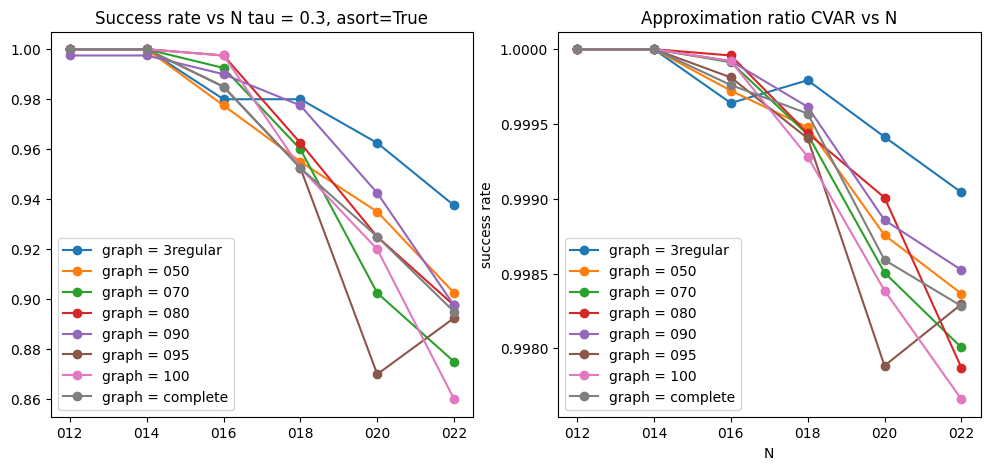

In [30]:
num_variables_list = [str(num).zfill(3) for num in range(12,24, 2)] 
graph_type_list = [ '3regular', '050', '070', '080', '090', '095', '100','complete']

r_list = range(400)
tau_list =[0.3] # [0.3, 0.4]
alpha_list = [0.01]
layer = 1
shots = None
tot_steps = range(5)
if_adsorting = True

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

for graph in graph_type_list:

    dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                            .format(graph,  shots)
    
    sr_array = np.zeros((len(num_opt_list), len(num_variables_list)))
    ar_array = np.zeros(len(num_variables_list))

    for n_qubits_i, num_variables in enumerate(num_variables_list):
        n_qubits = int(num_variables)

        N = n_qubits
        
        if graph == 'complete':
            # pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
            # num_pairs = len(pairs_all)
            # num_params = (n_qubits + 2*num_pairs) * layer
            # print(num_pairs, num_params)
            num_params = int(2*(N-1)*N/2 + N)
        elif graph == '3regular':
            num_params= int(2*(3*N)/2 + N)
        elif graph == '100':
            density = 1
            num_params = 2*round((N-1)*N*density/2) +N
        else:
            density = float(f"0.{int(graph)}")
            num_params = 2*round((N-1)*N*density/2) +N

        for alpha in alpha_list:

            for taui, tau in enumerate(tau_list):
                print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N, "parameters =", num_params)

                dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                    .format(num_variables, num_params, layer, alpha)
                
                for r in r_list:
                    # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
                    
                    file_dir_name = dir_name + '/r_{}'\
                                .format(r)
                    
                    filename = file_dir_name + '/ifadsorting_{}_tau_{}_entro.pkl'\
                                                            .format(if_adsorting,tau)
                    with open(filename, 'rb') as f:
                        data = pickle.load(f)

                    params_list = data["params_list"]
                    if len(params_list) != round(num_params):
                        print("error N, r = ", r, len(params_list))
                        
                    steps_exp_poss_dict = data["steps_exp_poss_dict"]
                    steps_cvar_dict = data["steps_cvar_dict"]
                    steps_entropy_dict = data["steps_entropy_dict"]
                    
                    final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
                    poss_list = list(final_exp_poss.values())
                    if poss_list[0] > alpha:
                        sr_array[0, n_qubits_i] += 1/len(r_list)
                    if sum(poss_list[:2]) > alpha:
                        sr_array[1, n_qubits_i] += 1/len(r_list)
                    if sum(poss_list[:3]) > alpha:
                        sr_array[2, n_qubits_i] += 1/len(r_list)

                    exp_opt = list(final_exp_poss.keys())[0]
                    cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]
                    ar_array[n_qubits_i] += (cvar/exp_opt) / len(r_list)

    # print("sr_array = ", sr_array)
    ax1.plot(num_variables_list, sr_array[0], "o-", label=f"graph = {graph}")
    # ax1.plot(tau_list, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
    # ax1.plot(tau_list, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

    ax2.plot(num_variables_list, ar_array, "o-", label=f"graph = {graph}")
    # print("ar_array = ", ar_array)

    ax1.set_title(f'Success rate vs N tau = {tau}, asort={if_adsorting}')
    ax2.set_title('Approximation ratio CVAR vs N')

    ax1.legend()
plt.legend()
plt.xlabel("N")
plt.ylabel("success rate")
plt.show()

PLOT PERFORMANCE AGAINST GRAPH DENSITY


tau =  0.3 alpha =  0.01 qubits =  12 parameters = 48

tau =  0.3 alpha =  0.01 qubits =  12 parameters = 78

tau =  0.3 alpha =  0.01 qubits =  12 parameters = 104

tau =  0.3 alpha =  0.01 qubits =  12 parameters = 118

tau =  0.3 alpha =  0.01 qubits =  12 parameters = 130

tau =  0.3 alpha =  0.01 qubits =  12 parameters = 138

tau =  0.3 alpha =  0.01 qubits =  12 parameters = 144

tau =  0.3 alpha =  0.01 qubits =  12 parameters = 144

tau =  0.3 alpha =  0.01 qubits =  12 parameters = 48

tau =  0.3 alpha =  0.01 qubits =  12 parameters = 78

tau =  0.3 alpha =  0.01 qubits =  12 parameters = 104

tau =  0.3 alpha =  0.01 qubits =  12 parameters = 118

tau =  0.3 alpha =  0.01 qubits =  12 parameters = 130

tau =  0.3 alpha =  0.01 qubits =  12 parameters = 138

tau =  0.3 alpha =  0.01 qubits =  12 parameters = 144

tau =  0.3 alpha =  0.01 qubits =  12 parameters = 144


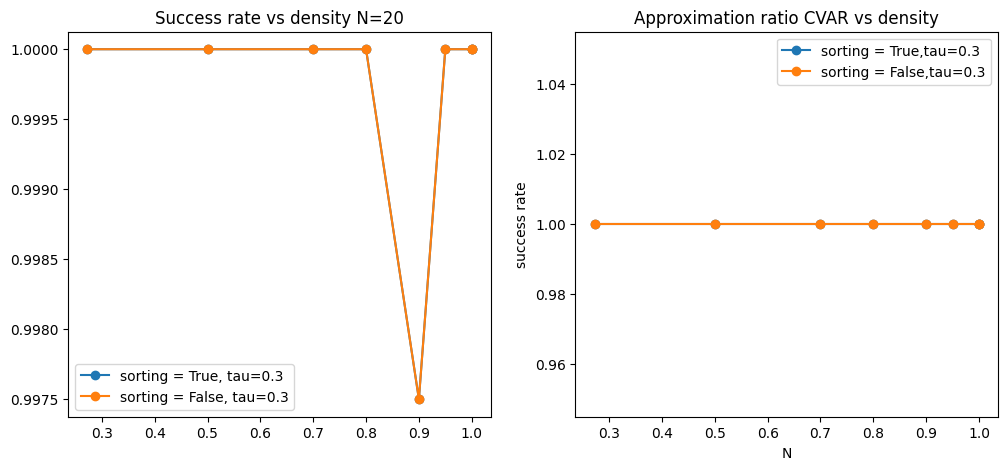

In [28]:
num_variables_list = [str(num).zfill(3) for num in range(12,14, 2)] 
graph_type_list = ['3regular', '050', '070', '080', '090', '095','100', 'complete']

r_list = range(400)
tau_list =[0.3] # [0.3, 0.4]
alpha_list = [0.01]
layer = 1
shots = None
tot_steps = range(5)
if_adsorting = False

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

for taui, tau in enumerate(tau_list):

    for if_adsorting in [True,False]:

        sr_array = np.zeros((len(num_opt_list), len(graph_type_list)))
        ar_array = np.zeros(len(graph_type_list))

        density_list = []

        for igraph, graph in enumerate(graph_type_list):

            dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                                    .format(graph,  shots)

            for n_qubits_i, num_variables in enumerate(num_variables_list):
                n_qubits = int(num_variables)

                N = n_qubits
                
                if graph == 'complete':
                    # pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
                    # num_pairs = len(pairs_all)
                    # num_params = (n_qubits + 2*num_pairs) * layer
                    # print(num_pairs, num_params)
                    density =1
                    num_params = int(2*(N-1)*N/2 + N)
                elif graph == '3regular':
                    num_params= int(2*(3*N)/2 + N)
                    density = ((3*N)/2)/((N-1)*N/2 )
                elif graph == '100':
                    density = 1
                    num_params = 2*round((N-1)*N*density/2) +N
                else:
                    density = float(f"0.{int(graph)}")
                    num_params = 2*round((N-1)*N*density/2) +N

                density_list.append(density)

                for alpha in alpha_list:

                    print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N, "parameters =", num_params)

                    dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                        .format(num_variables, num_params, layer, alpha)
                    
                    for r in r_list:
                        # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
                        
                        file_dir_name = dir_name + '/r_{}'\
                                    .format(r)
                        
                        filename = file_dir_name + '/ifadsorting_{}_tau_{}_entro.pkl'\
                                                                .format(if_adsorting,tau)
                        with open(filename, 'rb') as f:
                            data = pickle.load(f)

                        params_list = data["params_list"]
                        if len(params_list) != round(num_params):
                            print("error N, r = ", r, len(params_list))
                            
                        steps_exp_poss_dict = data["steps_exp_poss_dict"]
                        steps_cvar_dict = data["steps_cvar_dict"]
                        steps_entropy_dict = data["steps_entropy_dict"]
                        
                        final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
                        poss_list = list(final_exp_poss.values())
                        if poss_list[0] > alpha:
                            sr_array[0, igraph] += 1/len(r_list)
                        if sum(poss_list[:2]) > alpha:
                            sr_array[1, igraph] += 1/len(r_list)
                        if sum(poss_list[:3]) > alpha:
                            sr_array[2, igraph] += 1/len(r_list)

                        exp_opt = list(final_exp_poss.keys())[0]
                        cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]
                        ar_array[igraph] += (cvar/exp_opt) / len(r_list)


        # print("sr_array = ", sr_array)
        ax1.plot(density_list, sr_array[0], "o-", label=f"sorting = {if_adsorting}, tau={tau}")
        # ax1.plot(tau_list, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
        # ax1.plot(tau_list, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

        ax2.plot(density_list, ar_array, "o-", label=f"sorting = {if_adsorting},tau={tau}")

        # print("ar_array = ", ar_array)

        ax1.set_title(f'Success rate vs density N=20')
        ax2.set_title('Approximation ratio CVAR vs density')

ax1.legend()
plt.legend()
plt.xlabel("N")
plt.ylabel("success rate")
plt.show()


tau =  0.3 alpha =  0.01 qubits =  20 parameters = 80

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 210

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 286

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 324

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 362

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 380

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 400

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 400

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 80

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 210

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 286

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 324

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 362

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 380

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 400

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 400


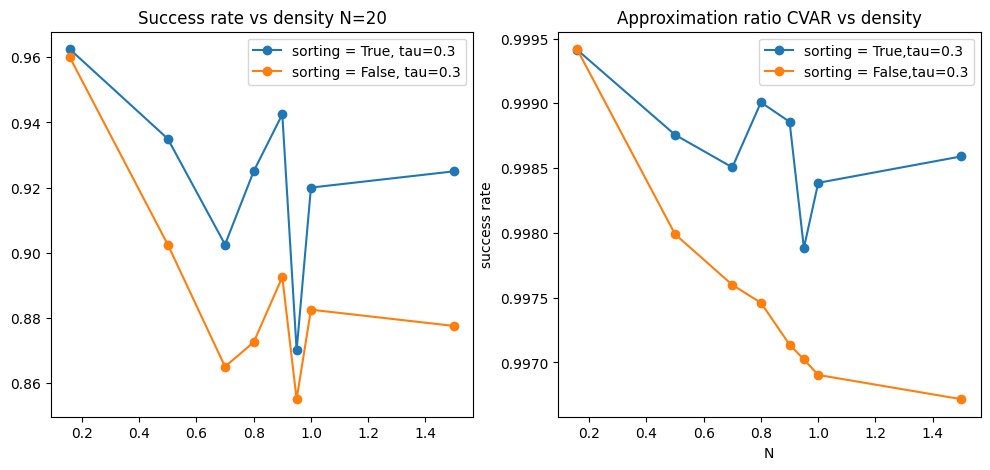

In [5]:
num_variables_list = [str(num).zfill(3) for num in range(20,22, 2)] 
graph_type_list = ['3regular', '050', '070', '080', '090', '095','100','complete']

#graph_type_list = [ '050', '070', '080', '090', '095','100','complete']

r_list = range(400)
tau_list =[0.3] # [0.3, 0.4]
alpha_list = [0.01]
layer = 1
shots = None
tot_steps = range(5)
if_adsorting = False

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

for taui, tau in enumerate(tau_list):

    for if_adsorting in [True,False]:

        sr_array = np.zeros((len(num_opt_list), len(graph_type_list)))
        ar_array = np.zeros(len(graph_type_list))

        density_list = []

        for igraph, graph in enumerate(graph_type_list):

            dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                                    .format(graph,  shots)

            for n_qubits_i, num_variables in enumerate(num_variables_list):
                n_qubits = int(num_variables)

                N = n_qubits
                
                if graph == 'complete':
                    # pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
                    # num_pairs = len(pairs_all)
                    # num_params = (n_qubits + 2*num_pairs) * layer
                    # print(num_pairs, num_params)
                    density =1
                    num_params = int(2*(N-1)*N/2 + N)
                    density = 1.5 #just for plot clarity
                elif graph == '3regular':
                    num_params= int(2*(3*N)/2 + N)
                    density = ((3*N)/2)/((N-1)*N/2 )
                elif graph == '100':
                    density = 1
                    num_params = 2*round((N-1)*N*density/2) +N
                else:
                    density = float(f"0.{int(graph)}")
                    num_params = 2*round((N-1)*N*density/2) +N

                density_list.append(density)

                for alpha in alpha_list:

                    print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N, "parameters =", num_params)

                    dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                        .format(num_variables, num_params, layer, alpha)
                    
                    for r in r_list:
                        # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
                        
                        file_dir_name = dir_name + '/r_{}'\
                                    .format(r)
                        
                        filename = file_dir_name + '/ifadsorting_{}_tau_{}_entro.pkl'\
                                                                .format(if_adsorting,tau)
                        with open(filename, 'rb') as f:
                            data = pickle.load(f)

                        params_list = data["params_list"]
                        if len(params_list) != round(num_params):
                            print("error N, r = ", r, len(params_list))
                            
                        steps_exp_poss_dict = data["steps_exp_poss_dict"]
                        steps_cvar_dict = data["steps_cvar_dict"]
                        steps_entropy_dict = data["steps_entropy_dict"]
                        
                        final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
                        poss_list = list(final_exp_poss.values())
                        if poss_list[0] > alpha:
                            sr_array[0, igraph] += 1/len(r_list)
                        if sum(poss_list[:2]) > alpha:
                            sr_array[1, igraph] += 1/len(r_list)
                        if sum(poss_list[:3]) > alpha:
                            sr_array[2, igraph] += 1/len(r_list)

                        exp_opt = list(final_exp_poss.keys())[0]
                        cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]
                        ar_array[igraph] += (cvar/exp_opt) / len(r_list)


        # print("sr_array = ", sr_array)
        ax1.plot(density_list, sr_array[0], "o-", label=f"sorting = {if_adsorting}, tau={tau}")
        # ax1.plot(tau_list, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
        # ax1.plot(tau_list, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

        ax2.plot(density_list, ar_array, "o-", label=f"sorting = {if_adsorting},tau={tau}")

        # print("ar_array = ", ar_array)

        ax1.set_title(f'Success rate vs density N=20')
        ax2.set_title('Approximation ratio CVAR vs density')

ax1.legend()
plt.legend()
plt.xlabel("N")
plt.ylabel("success rate")
plt.show()


tau =  0.3 alpha =  0.01 qubits =  18 parameters = 72

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 170

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 232

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 262

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 294

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 308

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 324

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 72

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 170

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 232

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 262

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 294

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 308

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 324

tau =  0.4 alpha =  0.01 qubits =  18 parameters = 72

tau =  0.4 alpha =  0.01 qubits =  18 parameters = 170

tau =  0.4 alpha =  0.01 qubits =  18 parameters = 232

tau =  0.4 alpha =  0.01 qubits =  18 parameters =

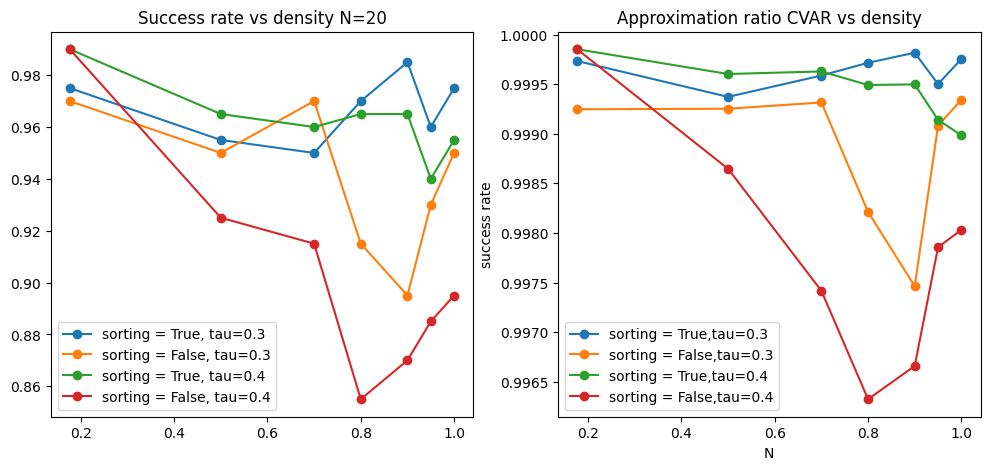

In [70]:
num_variables_list = [str(num).zfill(3) for num in range(18,20, 2)] 
graph_type_list = ['3regular', '050', '070', '080', '090', '095','complete']

r_list = range(200)
tau_list =[0.3,0.4] # [0.3, 0.4]
alpha_list = [0.01]
layer = 1
shots = None
tot_steps = range(5)
if_adsorting = False

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

for taui, tau in enumerate(tau_list):

    for if_adsorting in [True,False]:

        sr_array = np.zeros((len(num_opt_list), len(graph_type_list)))
        ar_array = np.zeros(len(graph_type_list))

        density_list = []

        for igraph, graph in enumerate(graph_type_list):

            dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                                    .format(graph,  shots)

            for n_qubits_i, num_variables in enumerate(num_variables_list):
                n_qubits = int(num_variables)

                N = n_qubits
                
                if graph == 'complete':
                    # pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
                    # num_pairs = len(pairs_all)
                    # num_params = (n_qubits + 2*num_pairs) * layer
                    # print(num_pairs, num_params)
                    density =1
                    num_params = int(2*(N-1)*N/2 + N)
                elif graph == '3regular':
                    num_params= int(2*(3*N)/2 + N)
                    density = ((3*N)/2)/((N-1)*N/2 )
                else:
                    density = float(f"0.{int(graph)}")
                    num_params = 2*round((N-1)*N*density/2) +N

                density_list.append(density)

                for alpha in alpha_list:

                    print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N, "parameters =", num_params)

                    dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                        .format(num_variables, num_params, layer, alpha)
                    
                    for r in r_list:
                        # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
                        
                        file_dir_name = dir_name + '/r_{}'\
                                    .format(r)
                        
                        filename = file_dir_name + '/ifadsorting_{}_tau_{}.pkl'\
                                                                .format(if_adsorting,tau)
                        with open(filename, 'rb') as f:
                            data = pickle.load(f)

                        params_list = data["params_list"]
                        if len(params_list) != round(num_params):
                            print("error N, r = ", r, len(params_list))
                            
                        steps_exp_poss_dict = data["steps_exp_poss_dict"]
                        steps_cvar_dict = data["steps_cvar_dict"]
                        steps_entropy_dict = data["steps_entropy_dict"]
                        
                        final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
                        poss_list = list(final_exp_poss.values())
                        if poss_list[0] > alpha:
                            sr_array[0, igraph] += 1/len(r_list)
                        if sum(poss_list[:2]) > alpha:
                            sr_array[1, igraph] += 1/len(r_list)
                        if sum(poss_list[:3]) > alpha:
                            sr_array[2, igraph] += 1/len(r_list)

                        exp_opt = list(final_exp_poss.keys())[0]
                        cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]
                        ar_array[igraph] += (cvar/exp_opt) / len(r_list)


        # print("sr_array = ", sr_array)
        ax1.plot(density_list, sr_array[0], "o-", label=f"sorting = {if_adsorting}, tau={tau}")
        # ax1.plot(tau_list, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
        # ax1.plot(tau_list, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

        ax2.plot(density_list, ar_array, "o-", label=f"sorting = {if_adsorting},tau={tau}")

        # print("ar_array = ", ar_array)

        ax1.set_title(f'Success rate vs density N=20')
        ax2.set_title('Approximation ratio CVAR vs density')

ax1.legend()
plt.legend()
plt.xlabel("N")
plt.ylabel("success rate")
plt.show()


tau =  0.3 alpha =  0.01 qubits =  20 parameters = 80

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 210

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 286

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 324

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 362

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 380

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 400
[0.99959434 0.99921976 0.99912171 0.99884386 0.99911413 0.99730924
 0.99869227] [0.9995943411242166, 0.99921976381062, 0.9991217088433332, 0.9988438601019984, 0.9991141320970766, 0.9973092388161824, 0.9986922737443612]


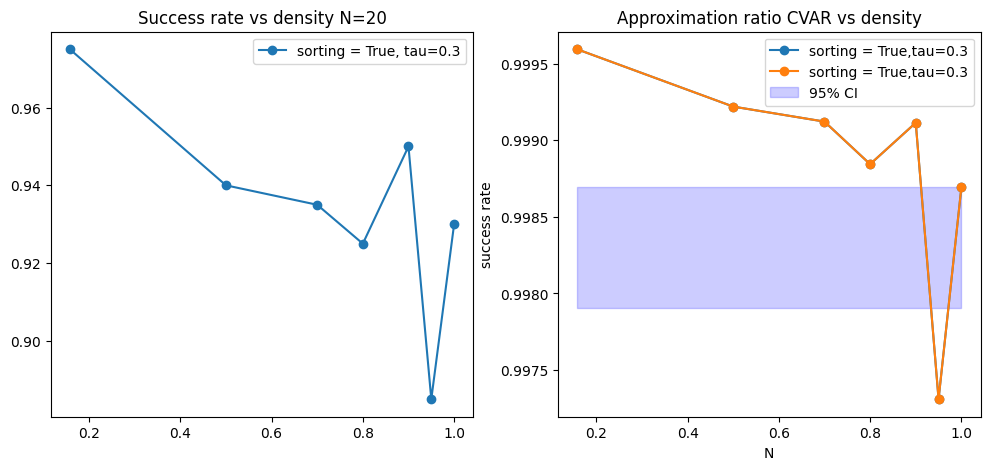

In [69]:
num_variables_list = [str(num).zfill(3) for num in range(20,22, 2)] 
graph_type_list = ['3regular', '050', '070', '080', '090', '095','complete']

r_list = range(200)
tau_list =[0.3] # [0.3, 0.4]
alpha_list = [0.01]
layer = 1
shots = None
tot_steps = range(5)
if_adsorting = False

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

for taui, tau in enumerate(tau_list):

    for if_adsorting in [True]:

        sr_array = np.zeros((len(num_opt_list), len(graph_type_list)))
        ar_array = np.zeros(len(graph_type_list))

        density_list = []

        meanlist = []
        stvlist = []

        for igraph, graph in enumerate(graph_type_list):

            dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                                    .format(graph,  shots)

            for n_qubits_i, num_variables in enumerate(num_variables_list):
                n_qubits = int(num_variables)

                N = n_qubits
                
                if graph == 'complete':
                    # pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
                    # num_pairs = len(pairs_all)
                    # num_params = (n_qubits + 2*num_pairs) * layer
                    # print(num_pairs, num_params)
                    density =1
                    num_params = int(2*(N-1)*N/2 + N)
                elif graph == '3regular':
                    num_params= int(2*(3*N)/2 + N)
                    density = ((3*N)/2)/((N-1)*N/2 )
                else:
                    density = float(f"0.{int(graph)}")
                    num_params = 2*round((N-1)*N*density/2) +N

                density_list.append(density)

                for alpha in alpha_list:

                    print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N, "parameters =", num_params)

                    dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                        .format(num_variables, num_params, layer, alpha)
                    
                    approx = [] 

                    for r in r_list:
                        # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
                        
                        file_dir_name = dir_name + '/r_{}'\
                                    .format(r)
                        
                        filename = file_dir_name + '/ifadsorting_{}_tau_{}.pkl'\
                                                                .format(if_adsorting,tau)
                        with open(filename, 'rb') as f:
                            data = pickle.load(f)

                        params_list = data["params_list"]
                        if len(params_list) != round(num_params):
                            print("error N, r = ", r, len(params_list))
                            
                        steps_exp_poss_dict = data["steps_exp_poss_dict"]
                        steps_cvar_dict = data["steps_cvar_dict"]
                        steps_entropy_dict = data["steps_entropy_dict"]
                        
                        final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
                        poss_list = list(final_exp_poss.values())
                        if poss_list[0] > alpha:
                            sr_array[0, igraph] += 1/len(r_list)
                        if sum(poss_list[:2]) > alpha:
                            sr_array[1, igraph] += 1/len(r_list)
                        if sum(poss_list[:3]) > alpha:
                            sr_array[2, igraph] += 1/len(r_list)

                        exp_opt = list(final_exp_poss.keys())[0]
                        cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]
                        ar_array[igraph] += (cvar/exp_opt) / len(r_list)
                        approx.append(cvar/exp_opt)
                    
                    meanlist.append(np.mean(approx))
                    stvlist.append(np.std(approx, axis=0, ddof=1))


        # print("sr_array = ", sr_array)
        ax1.plot(density_list, sr_array[0], "o-", label=f"sorting = {if_adsorting}, tau={tau}")
        # ax1.plot(tau_list, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
        # ax1.plot(tau_list, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

        ax2.plot(density_list, ar_array, "o-", label=f"sorting = {if_adsorting},tau={tau}")
        ax2.plot(density_list, meanlist, "o-", label=f"sorting = {if_adsorting},tau={tau}")
        print(ar_array, meanlist)

        z = 1.96  # Z-score for 95% confidence

        # Compute confidence intervals
        for i in range(len(meanlist)):
            margin_of_error = z * (stvlist[i] / np.sqrt(len(r_list)))
            lower_bound = meanlist[i] - margin_of_error 
            upper_bound = meanlist[i]  
        
        ax2.fill_between(density_list, lower_bound, upper_bound, color="blue", alpha=0.2, label="95% CI")

        # print("ar_array = ", ar_array)

        ax1.set_title(f'Success rate vs density N=20')
        ax2.set_title('Approximation ratio CVAR vs density')

ax1.legend()
plt.legend()
plt.xlabel("N")
plt.ylabel("success rate")
plt.show()

In [ ]:
        std_dev = np.std(ar_array, axis=0, ddof=1)
        z = 1.96  # Z-score for 95% confidence

        # Compute confidence intervals
        margin_of_error = z * (std_dev / np.sqrt(len(r_list)))
        lower_bound = [mean_success_rate - margin_of_error for mean_success_rate in ar_array]
        upper_bound = [mean_success_rate + margin_of_error for mean_success_rate in ar_array]
        ax2.fill_between(density_list, lower_bound, upper_bound, color="blue", alpha=0.2, label="95% CI")

Mean: 0.49559026775798837
95% CI: (0.4812098054598219, 0.5099707300561548)


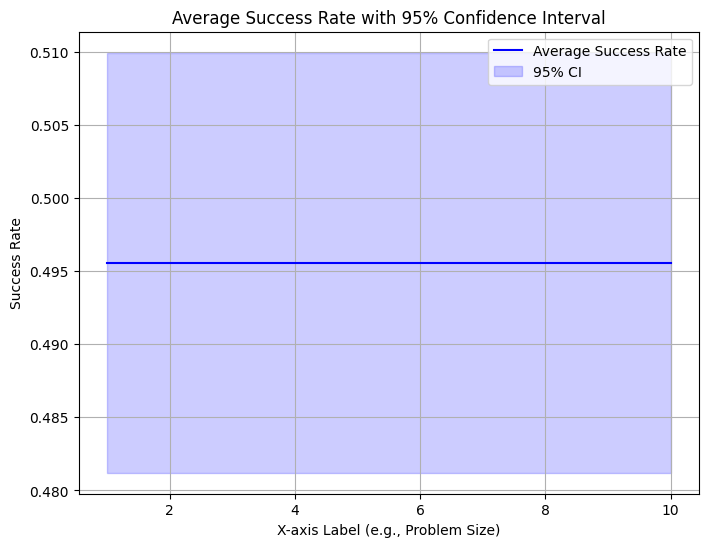

In [60]:
import matplotlib.pyplot as plt

# Example data: success rates for 1600 instances
success_rates = np.random.rand(1600)  # Replace with your data

# Compute statistics
mean_success_rate = np.mean(success_rates)
std_dev = np.std(success_rates, ddof=1)  # Sample standard deviation
n = len(success_rates)

# 95% Confidence Interval
z = 1.96  # Z-score for 95% confidence
margin_of_error = z * (std_dev / np.sqrt(n))
lower_bound = mean_success_rate - margin_of_error
upper_bound = mean_success_rate + margin_of_error

print("Mean:", mean_success_rate)
print("95% CI:", (lower_bound, upper_bound))

# Simulate means for plotting (mock data for example purposes)
x = np.arange(1, 11)  # Example x-axis values (e.g., problem sizes)
means = np.full_like(x, mean_success_rate, dtype=float)  # Mock means (constant)
lower_bounds = np.full_like(x, lower_bound, dtype=float)  # Constant lower bound
upper_bounds = np.full_like(x, upper_bound, dtype=float)  # Constant upper bound

# Plot the average line
plt.figure(figsize=(8, 6))
plt.plot(x, means, label="Average Success Rate", color="blue")

# Add the shaded 95% confidence interval
plt.fill_between(x, lower_bounds, upper_bounds, color="blue", alpha=0.2, label="95% CI")

# Customize the plot
plt.xlabel("X-axis Label (e.g., Problem Size)")
plt.ylabel("Success Rate")
plt.title("Average Success Rate with 95% Confidence Interval")
plt.legend()
plt.grid()
plt.show()

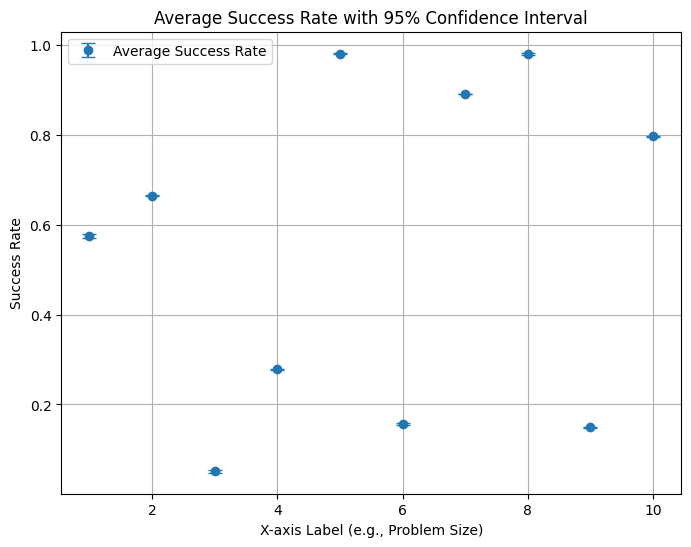

In [59]:
# Example data
x = np.arange(1, 11)  # Example x-axis values
means = np.random.rand(10)  # Example mean success rates
std_devs = np.random.rand(10) * 0.1  # Example standard deviations

n = 1600  # Number of instances
z = 1.96  # Z-score for 95% confidence

# Compute margin of error for 95% confidence interval
margin_of_errors = z * (std_devs / np.sqrt(n))

# Plot with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(x, means, yerr=margin_of_errors, fmt='o', capsize=5, label="Average Success Rate")
plt.xlabel("X-axis Label (e.g., Problem Size)")
plt.ylabel("Success Rate")
plt.title("Average Success Rate with 95% Confidence Interval")
plt.legend()
plt.grid()
plt.show()

(8, 6)

tau =  0.3 alpha =  0.01 qubits =  12 parameters = 48

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 56

tau =  0.3 alpha =  0.01 qubits =  16 parameters = 64

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 72

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 80

tau =  0.3 alpha =  0.01 qubits =  22 parameters = 88

tau =  0.3 alpha =  0.01 qubits =  12 parameters = 78

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 106

tau =  0.3 alpha =  0.01 qubits =  16 parameters = 136

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 170

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 210

tau =  0.3 alpha =  0.01 qubits =  22 parameters = 254

tau =  0.3 alpha =  0.01 qubits =  12 parameters = 104

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 142

tau =  0.3 alpha =  0.01 qubits =  16 parameters = 184

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 232

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 286

tau =  0.3 alpha =  0.01 qubits =  22 parameter

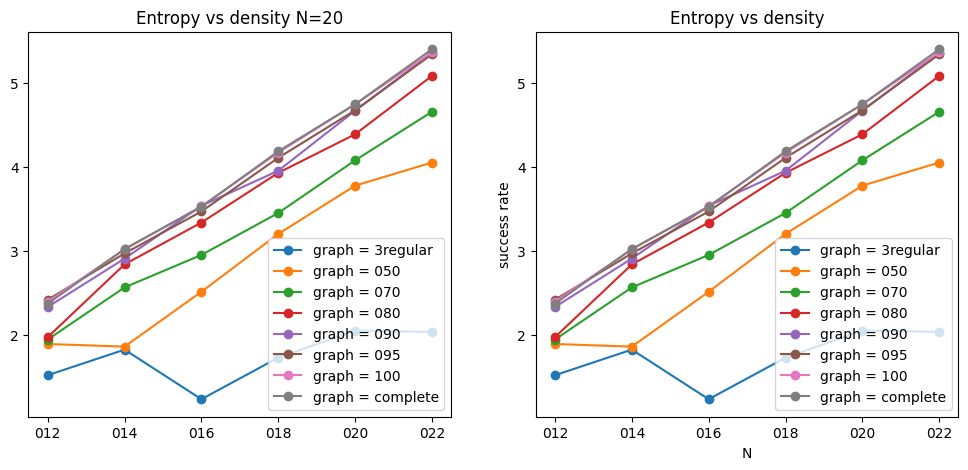

In [6]:
num_variables_list = [str(num).zfill(3) for num in range(12,24, 2)] 
graph_type_list = ['3regular', '050', '070', '080', '090', '095','100', 'complete']


r_list = range(400)
tau_list =[0.3] # [0.3, 0.4]
alpha_list = [0.01]
layer = 1
shots = None
tot_steps = range(5)
if_adsorting = False

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

for taui, tau in enumerate(tau_list):

    for if_adsorting in [True]:

        density_list = []

        array_all_entropies = np.zeros((len(graph_type_list),len(num_variables_list))) 
        print(array_all_entropies.shape)
        for igraph, graph in enumerate(graph_type_list):

            dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                                    .format(graph,  shots)

            ar_array = np.zeros(len(num_variables_list))
            for n_qubits_i, num_variables in enumerate(num_variables_list):
                n_qubits = int(num_variables)

                N = n_qubits
                
                if graph == 'complete':
                    # pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
                    # num_pairs = len(pairs_all)
                    # num_params = (n_qubits + 2*num_pairs) * layer
                    # print(num_pairs, num_params)
                    density =1
                    num_params = int(2*(N-1)*N/2 + N)
                elif graph == '3regular':
                    num_params= int(2*(3*N)/2 + N)
                    density = ((3*N)/2)/((N-1)*N/2 )
                elif graph == '100':
                    density = 1
                    num_params = 2*round((N-1)*N*density/2) +N
                else:
                    density = float(f"0.{int(graph)}")
                    num_params = 2*round((N-1)*N*density/2) +N

                density_list.append(density)

                for alpha in alpha_list:

                    print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N, "parameters =", num_params)

                    dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                        .format(num_variables, num_params, layer, alpha)
                    
                    max_entropy = 0 

                    for r in r_list:
                        # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
                        
                        file_dir_name = dir_name + '/r_{}'\
                                    .format(r)
                        
                        filename = file_dir_name + '/ifadsorting_{}_tau_{}_entro.pkl'\
                                                                .format(if_adsorting,tau)
                        with open(filename, 'rb') as f:
                            data = pickle.load(f)

                        params_list = data["params_list"]
                        if len(params_list) != round(num_params):
                            print("error N, r = ", r, len(params_list))
                            
                        # steps_exp_poss_dict = data["steps_exp_poss_dict"]
                        # steps_cvar_dict = data["steps_cvar_dict"]
                        steps_entropy_dict = data["steps_entropy_dict"]

                        max_key = max(data["steps_entropy_dict"], key=data["steps_entropy_dict"].get)
                        max_value = data["steps_entropy_dict"][max_key]

                        max_entropy += max_value
                        
                        # final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
                        # poss_list = list(final_exp_poss.values())
                        # if poss_list[0] > alpha:
                        #     sr_array[0, igraph] += 1/len(r_list)
                        # if sum(poss_list[:2]) > alpha:
                        #     sr_array[1, igraph] += 1/len(r_list)
                        # if sum(poss_list[:3]) > alpha:
                        #     sr_array[2, igraph] += 1/len(r_list)

                        # exp_opt = list(final_exp_poss.keys())[0]
                        # cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]
                        # ar_array[igraph] += (cvar/exp_opt) / len(r_list)

                    ar_array[n_qubits_i] =max_entropy/len(r_list)

                array_all_entropies[igraph,n_qubits_i] = ar_array[n_qubits_i]

            # print("sr_array = ", sr_array)
            ax1.plot(num_variables_list, ar_array, "o-", label=f"graph = {graph}")
            # ax1.plot(tau_list, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
            # ax1.plot(tau_list, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

            ax2.plot(num_variables_list, ar_array, "o-", label=f"graph = {graph}")
            # print("ar_array = ", ar_array)

            ax1.set_title(f'Entropy vs density N=20')
            ax2.set_title('Entropy vs density')

             

            
print('array all entropies', array_all_entropies)
# ax1.plot(num_variables_list, [int(num_variables)  for num_variables in num_variables_list], "o-", label=f"linear")
ax1.legend()
plt.legend()
plt.xlabel("N")
plt.ylabel("success rate")
plt.show()

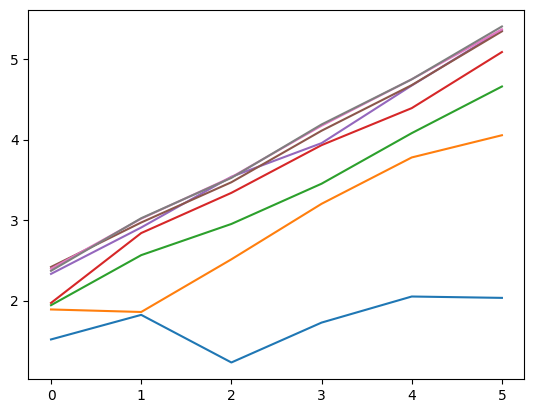

In [7]:
for igraph,_ in enumerate(graph_type_list):
    plt.plot(range(len(num_variables_list)), array_all_entropies[igraph])

In [9]:
from scipy.optimize import curve_fit

# 1. Define the candidate models
def linear_model(x, a, b):
    return a * x + b

def sublinear_model(x, a, b):
    return a * np.sqrt(x) + b

def polynomial_model(x, a, b, c):
    return a * x**2 + b * x + c

# 2. Generate or load your data (replace these with your data)
# x_data = np.linspace(1, 10, 50)  # Replace with your x values
# y_data = 2.5 * x_data + 3 + np.random.normal(0, 2, len(x_data))  # Replace with your y values
x_data = [float(variable) for variable in num_variables_list]
y_data = array_all_entropies[0]
print(x_data)
print(y_data)

# 3. Fit the data to each model
params_linear, _ = curve_fit(linear_model, x_data, y_data)
params_sublinear, _ = curve_fit(sublinear_model, x_data, y_data)
params_polynomial, _ = curve_fit(polynomial_model, x_data, y_data)

# 4. Calculate goodness-of-fit (sum of squared residuals)
def compute_ssr(model, params, x, y):
    y_fit = model(x, *params)
    residuals = y - y_fit
    return np.sum(residuals**2)

ssr_linear = compute_ssr(linear_model, params_linear, x_data, y_data)
ssr_sublinear = compute_ssr(sublinear_model, params_sublinear, x_data, y_data)
ssr_polynomial = compute_ssr(polynomial_model, params_polynomial, x_data, y_data)

# Print SSR values for comparison
print(f"Sum of Squared Residuals (SSR):")
print(f"  Linear Model: {ssr_linear:.2f}")
print(f"  Sublinear Model: {ssr_sublinear:.2f}")
print(f"  Polynomial Model: {ssr_polynomial:.2f}")

# 5. Plot the data and fits
plt.scatter(x_data, y_data, label="Data", color="blue")

# Generate x values for plotting fits
x_fit = np.linspace(min(x_data), max(x_data), 100)

# Plot the fitted models
plt.plot(x_fit, linear_model(x_fit, *params_linear), label="Linear Fit", color="red")
plt.plot(x_fit, sublinear_model(x_fit, *params_sublinear), label="Sublinear Fit", color="green")
plt.plot(x_fit, polynomial_model(x_fit, *params_polynomial), label="Polynomial Fit", color="orange")

# Add labels, legend, and show the plot
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Model Fits")
plt.show()

[12.0, 14.0, 16.0, 18.0, 20.0, 22.0]
[1.51855408 1.8236138  1.23261422 1.72769877 2.05149745 2.03456969]


TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [31]:
max_key = max(data["steps_entropy_dict"], key=data["steps_entropy_dict"].get)
max_value = data["steps_entropy_dict"][max_key]
print(max_value)

4.226455909393496



tau =  0.3 alpha =  0.01 qubits =  14 parameters = 142
[-6.406853007629837e-16, -1.2813706015259676e-15, 0.35289510166049914, 0.35289510166049987, 0.3528951016604997, 0.35289510166049987, 0.35289510166049987, 0.4047287773270295, 0.46452552876939, 0.6401891861291229, 0.640189186129122, 0.6401891861291223, 0.7579473048492258, 0.9142051675866217, 0.9235038475914668, 1.0095520046135904, 1.009552004613591, 1.0217658405862609, 1.0238789674086402, 1.0248060302278912, 1.1332617189089778, 1.2493070466776348, 1.2493070466776326, 1.2554761953536362, 1.279836454438081, 1.3412123147213126, 1.5361436843498981, 1.5810409293950893, 1.5950002262797351, 1.7680035980340363, 1.8977562768813891, 2.0894160434458806, 2.128421000752739, 2.220174313638463, 2.238698222529884, 2.248102624191985, 2.268202528959344, 2.381378124326772, 2.517344903199186, 2.629910059094448, 2.629910059094449, 2.6299100590944517, 2.732722773413447, 2.7327344526104413, 2.8030540596210987, 2.800281551085904, 2.800281551085903, 2.80028

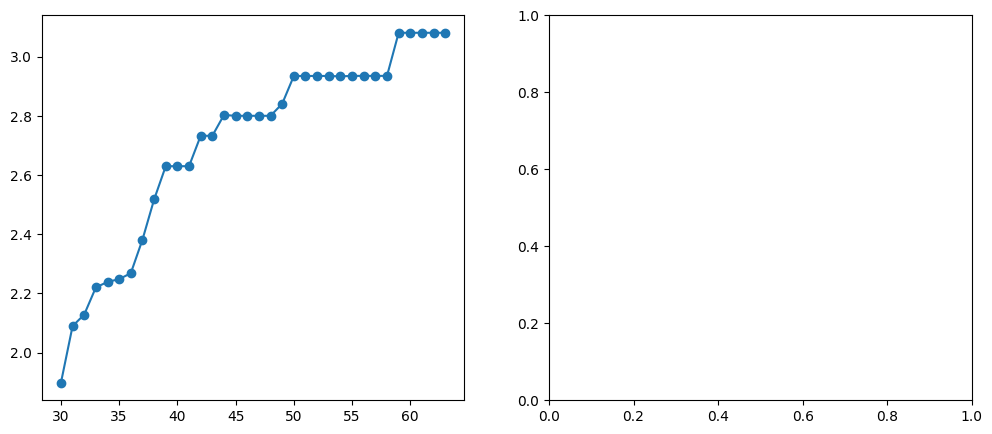

In [ ]:
num_variables_list = [str(num).zfill(3) for num in range(14,16, 2)] 
graph_type_list = ['070']


r_list = range(186,187)
tau_list =[0.3] # [0.3, 0.4]
alpha_list = [0.01]
layer = 1
shots = None
tot_steps = range(5)
ifadsorting = False

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

for taui, tau in enumerate(tau_list):

    for if_adsorting in [True]:

        density_list = []

        for igraph, graph in enumerate(graph_type_list):

            dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                                    .format(graph,  shots)

            ar_array = np.zeros(len(num_variables_list))
            for n_qubits_i, num_variables in enumerate(num_variables_list):
                n_qubits = int(num_variables)

                N = n_qubits
                
                if graph == 'complete':
                    # pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
                    # num_pairs = len(pairs_all)
                    # num_params = (n_qubits + 2*num_pairs) * layer
                    # print(num_pairs, num_params)
                    density =1
                    num_params = int(2*(N-1)*N/2 + N)
                elif graph == '3regular':
                    num_params= int(2*(3*N)/2 + N)
                    density = ((3*N)/2)/((N-1)*N/2 )
                else:
                    density = float(f"0.{int(graph)}")
                    num_params = 2*round((N-1)*N*density/2) +N

                density_list.append(density)

                for alpha in alpha_list:

                    print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N, "parameters =", num_params)

                    dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                        .format(num_variables, num_params, layer, alpha)
                    
                    max_entropy = 0 

                    for r in r_list:
                                                # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
                        
                        file_dir_name = dir_name + '/r_{}'\
                                    .format(r)
                        
                        filename = file_dir_name + '/ifadsorting_{}_tau_{}_entro.pkl'\
                                                                .format(if_adsorting,tau)
                        with open(filename, 'rb') as f:
                            data = pickle.load(f)

                        params_list = data["params_list"]
                        if len(params_list) != round(num_params):
                            print("error N, r = ", r, len(params_list))
                            
                        # steps_exp_poss_dict = data["steps_exp_poss_dict"]
                        # steps_cvar_dict = data["steps_cvar_dict"]
                        steps_entropy_dict = data["steps_entropy_dict"]

                        entropi = data['entropy_list']
                        print(entropi)
                        print(max(entropi))
                        print(len(entropi))
                        print('r',r)

print(round((0.7*n_qubits*(n_qubits-1)/2)))

edgi = round((0.7*n_qubits*(n_qubits-1)/2))

ax1.plot(range(edgi)[30:], entropi[30:], "o-", label=f"linear")

print(steps_entropy_dict)
print(max(entropi))




tau =  0.3 alpha =  0.01 qubits =  14 parameters = 56
[3.2034265038149176e-16, 0.06684262468273643, 0.06684262468273511, 0.14796605710356228, 0.14796605710356125, 0.14796605710356098, 0.4017645246148977, 0.4017645246148976, 0.40212077377401023, 0.41312515148840073, 0.5713513435352919, 0.8979118644113024, 1.0698475700949004, 1.2311581400558016, 1.2311581400557985, 1.2311581400557976, 1.2311581400557996, 1.2312571804295913, 1.2596315660095594, 1.2596315660095572, 1.2596315660095554]
21
21

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 106
[0.0, 1.6017132519074586e-16, -3.2034265038149176e-16, 1.6017132519074586e-16, -3.2034265038149176e-16, 0.02637849510664395, 0.026378495106645198, 0.10696020098854733, 0.10696020098854742, 0.14066358822514508, 0.14066358822514494, 0.14130459202491844, 0.14130459202491824, 0.3659595974592323, 0.4134436565502071, 0.6294146277369481, 0.9145976805884546, 1.1195697999883387, 1.2677731346416126, 1.484559910811594, 1.5069502736311953, 1.699304141049371, 

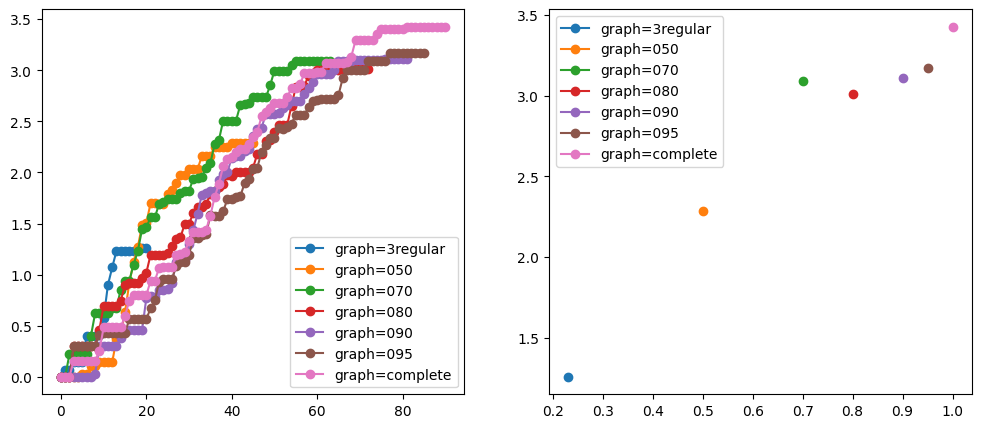

In [27]:
num_variables_list = [str(num).zfill(3) for num in range(14,16, 2)] 
# graph_type_list = ['050']
graph_type_list = ['3regular', '050', '070', '080', '090', '095','complete']


r_list = range(199,200)
tau_list =[0.3] # [0.3, 0.4]
alpha_list = [0.01]
layer = 1
shots = None
tot_steps = range(5)
ifadsorting = False

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

for taui, tau in enumerate(tau_list):

    for if_adsorting in [False]:

        density_list = []

        for igraph, graph in enumerate(graph_type_list):

            dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                                    .format(graph,  shots)

            ar_array = np.zeros(len(num_variables_list))
            for n_qubits_i, num_variables in enumerate(num_variables_list):
                n_qubits = int(num_variables)

                N = n_qubits
                
                if graph == 'complete':
                    # pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
                    # num_pairs = len(pairs_all)
                    # num_params = (n_qubits + 2*num_pairs) * layer
                    # print(num_pairs, num_params)
                    density =1
                    num_params = int(2*(N-1)*N/2 + N)
                elif graph == '3regular':
                    num_params= int(2*(3*N)/2 + N)
                    density = ((3*N)/2)/((N-1)*N/2 )
                else:
                    density = float(f"0.{int(graph)}")
                    num_params = 2*round((N-1)*N*density/2) +N

                density_list.append(density)

                for alpha in alpha_list:

                    print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N, "parameters =", num_params)

                    dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                        .format(num_variables, num_params, layer, alpha)
                    
                    max_entropy = 0 

                    for r in r_list:
                                                # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
                        
                        file_dir_name = dir_name + '/r_{}'\
                                    .format(r)
                        
                        filename = file_dir_name + '/ifadsorting_{}_tau_{}_entro.pkl'\
                                                                .format(if_adsorting,tau)
                        with open(filename, 'rb') as f:
                            data = pickle.load(f)

                        params_list = data["params_list"]
                        if len(params_list) != round(num_params):
                            print("error N, r = ", r, len(params_list))
                            
                        # steps_exp_poss_dict = data["steps_exp_poss_dict"]
                        # steps_cvar_dict = data["steps_cvar_dict"]
                        steps_entropy_dict = data["steps_entropy_dict"]

                        entropi = data['entropy_list']
                        print(entropi)
                        print(len(entropi))

                    print(round((density*n_qubits*(n_qubits-1)/2)))

                    edgi = round((density*n_qubits*(n_qubits-1)/2))

                    ax1.plot(range(edgi), entropi, "o-", label=f"graph={graph}")
                    ax2.plot(density, max(entropi), "o-", label=f"graph={graph}")

ax1.legend()
ax2.legend()
print(steps_entropy_dict)
print(max(entropi))


tau =  0.3 alpha =  0.01 qubits =  14 parameters = 56

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 106

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 142

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 160

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 178

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 186

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 196
[1.3058604848123472, 2.163174277875868, 2.784860985425975, 2.8145278532230766, 2.9951220879094302, 2.8814172783707233, 3.0353958140197874]
[1.3058604848123454, 2.1629220002914624, 2.7842378610711886, 2.8136487387729283, 2.994026427340351, 2.8798186164397945, 3.033978342340977]


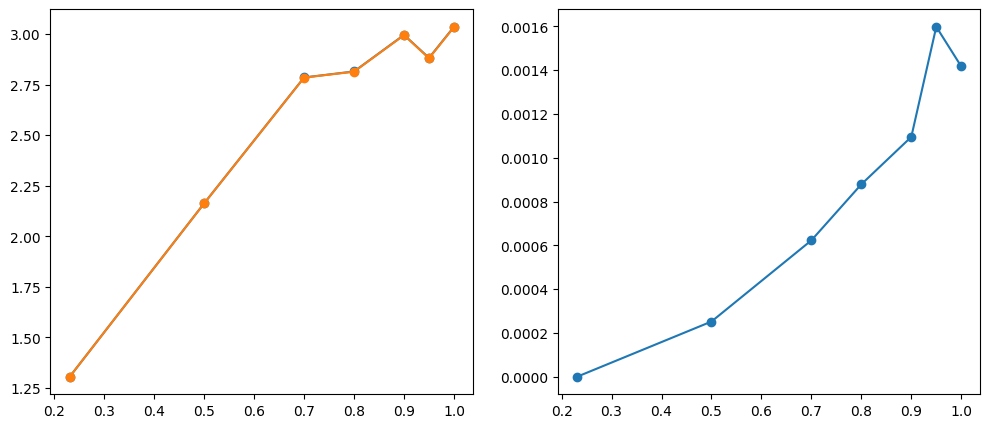

In [51]:
num_variables_list = [str(num).zfill(3) for num in range(14,16, 2)] 
# graph_type_list = ['050']
graph_type_list = ['3regular', '050', '070', '080', '090', '095','complete']


r_list = range(100,200)
tau_list =[0.3] # [0.3, 0.4]
alpha_list = [0.01]
layer = 1
shots = None
tot_steps = range(5)
ifadsorting = False

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

for taui, tau in enumerate(tau_list):

    for if_adsorting in [True]:

        density_list = []
        entropy_list = []
        entropy_list2 = []

        for igraph, graph in enumerate(graph_type_list):

            dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                                    .format(graph,  shots)

            ar_array = np.zeros(len(num_variables_list))
            for n_qubits_i, num_variables in enumerate(num_variables_list):
                n_qubits = int(num_variables)

                N = n_qubits
                
                if graph == 'complete':
                    # pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
                    # num_pairs = len(pairs_all)
                    # num_params = (n_qubits + 2*num_pairs) * layer
                    # print(num_pairs, num_params)
                    density =1
                    num_params = int(2*(N-1)*N/2 + N)
                elif graph == '3regular':
                    num_params= int(2*(3*N)/2 + N)
                    density = ((3*N)/2)/((N-1)*N/2 )
                else:
                    density = float(f"0.{int(graph)}")
                    num_params = 2*round((N-1)*N*density/2) +N

                density_list.append(density)

                for alpha in alpha_list:

                    print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N, "parameters =", num_params)

                    dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                        .format(num_variables, num_params, layer, alpha)
                    
                    max_entropy = 0 
                    max_entropy2 = 0 

                    for r in r_list:
                                                # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
                        
                        file_dir_name = dir_name + '/r_{}'\
                                    .format(r)
                        
                        filename = file_dir_name + '/ifadsorting_{}_tau_{}_entro.pkl'\
                                                                .format(if_adsorting,tau)
                        with open(filename, 'rb') as f:
                            data = pickle.load(f)

                        params_list = data["params_list"]
                        if len(params_list) != round(num_params):
                            print("error N, r = ", r, len(params_list))
                            
                        # steps_exp_poss_dict = data["steps_exp_poss_dict"]
                        # steps_cvar_dict = data["steps_cvar_dict"]
                        steps_entropy_dict = data["steps_entropy_dict"]

                        entropi = data['entropy_list']
                        # print(entropi)
                        # print(len(entropi))
                        # if max(entropi)-steps_entropy_dict['entropy_0']> 10**(-7):
                        #     print('max was before', max(entropi), steps_entropy_dict['entropy_0'], r, graph)
                        # else:
                        #     print('max is end')

                        max_entropy += max(entropi)
                        max_key = max(data["steps_entropy_dict"], key=data["steps_entropy_dict"].get)
                        max_entropy2 += data["steps_entropy_dict"][max_key]
                    
                    entropy_list.append(max_entropy/len(r_list))
                    entropy_list2.append(max_entropy2/len(r_list))
                    # print(round((density*n_qubits*(n_qubits-1)/2)))

                    # edgi = round((density*n_qubits*(n_qubits-1)/2))

                    # ax1.plot(range(edgi), entropi, "o-", label=f"graph={graph}")
                    # ax2.plot(density, max(entropi), "o-", label=f"graph={graph}")

print(entropy_list)
print(entropy_list2)
ax1.plot(density_list, entropy_list, "o-", label=f"graph={graph}")
ax1.plot(density_list, entropy_list2, "o-", label=f"graph={graph}")
ax2.plot(density_list, [a - b for a, b in zip(entropy_list, entropy_list2)], "o-", label=f"graph={graph}")
# ax1.legend()
# ax2.legend()
# print(steps_entropy_dict)
# print(max(entropi))

STOP HERE!!!!!!!!


 step =  4 tau =  0.3 alpha =  0.01 N = 16

 step =  4 tau =  0.6 alpha =  0.01 N = 16
sr_array =  [[0.98 0.8 ]
 [0.99 0.9 ]
 [0.   0.  ]]
ar_array =  [[0.99971794 0.99048889]
 [0.99985202 0.99681511]
 [0.         0.        ]]

 step =  4 tau =  0.3 alpha =  0.01 N = 18

 step =  4 tau =  0.6 alpha =  0.01 N = 18
sr_array =  [[0.96 0.66]
 [0.96 0.79]
 [0.   0.  ]]
ar_array =  [[0.99971446 0.98513275]
 [0.99938582 0.99419626]
 [0.         0.        ]]

 step =  4 tau =  0.3 alpha =  0.01 N = 20

 step =  4 tau =  0.6 alpha =  0.01 N = 20
sr_array =  [[0.87 0.7 ]
 [0.93 0.8 ]
 [0.   0.  ]]
ar_array =  [[0.99530628 0.9845846 ]
 [0.99756299 0.99229514]
 [0.         0.        ]]


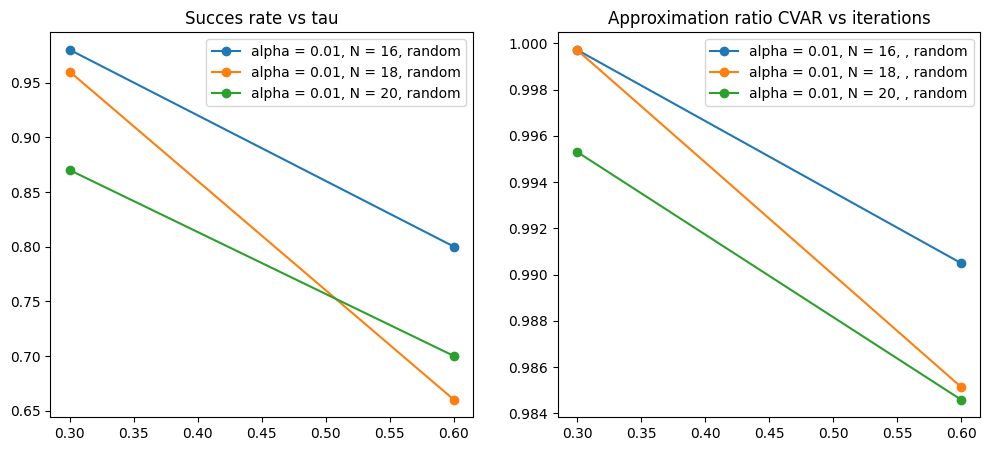

In [117]:
r_list = range(100)
tau_list = [0.3,0.6]
alpha_list = [0.01]

tot_steps = range(5)


num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

dir_0 = './data_iter' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

dir_0_adap =  './data_iter_adap_sorting' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

alpha = 0.01 
tau = 0.3

num_variables_list = [str(num).zfill(3) for num in range(16,22, 2)] 

for num_variables in num_variables_list:


    sr_array = np.zeros((len(num_opt_list), len(tau_list)))
    ar_array = np.zeros((len(num_opt_list), len(tau_list)))


    n_qubits = int(num_variables)

    N = n_qubits

    pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
    num_pairs = len(pairs_all)
    num_params = (n_qubits + 2*num_pairs) * layer

    for taui, tau in enumerate(tau_list):
        print("\n step = ", step, "tau = ", tau, "alpha = ", alpha, "N =", N)

        dir_name =  '/num_variables_{}/params_{}_layer_{}/alpha_{}/initial_{}'\
                    .format(num_variables, num_params, layer, alpha, initialization)

        
        for r in r_list:
            # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"

            file_dir_name = dir_name + '/r_{}'\
                                .format(r)
            
            filename = dir_0 + file_dir_name + '/tau_{}_random.pkl'.format(tau)
                            
            with open(filename, 'rb') as f:
                data = pickle.load(f)

            filename_adap = dir_0_adap + file_dir_name + '/tau_{}.pkl'.format(tau)
                            
            with open(filename_adap, 'rb') as f:
                data_adap = pickle.load(f)

            params_list = data["params_list"]
            if len(params_list) != round(N**2):
                print("error N, r = ", r, len(params_list))

            params_list = data_adap["params_list"]
            if len(params_list) != round(N**2):
                print("error N, r = ", r, len(params_list))

            steps_exp_poss_dict = data["steps_exp_poss_dict"]
            steps_cvar_dict = data["steps_cvar_dict"]
            final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
            poss_list = list(final_exp_poss.values())

            steps_exp_poss_dict_adap = data_adap["steps_exp_poss_dict"]
            steps_cvar_dict_adap = data_adap["steps_cvar_dict"]
            final_exp_poss_adap = steps_exp_poss_dict_adap[f"step_{len(tot_steps)-1}"]["l_1"]
            poss_list_adap = list(final_exp_poss_adap.values())


            if poss_list[0] > alpha:
                sr_array[0, taui] += 1/len(r_list)
            if poss_list_adap[0] > alpha:
                sr_array[1, taui] += 1/len(r_list)

            # if sum(poss_list[:3]) > alpha:
            #     sr_array[2, step] += 1/len(r_list)

            exp_opt = list(final_exp_poss.keys())[0]
            cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]

            ar_array[0,taui] += (cvar/exp_opt) / len(r_list)

            exp_opt = list(final_exp_poss_adap.keys())[0]
            cvar = steps_cvar_dict_adap[f"step_{len(tot_steps)-1}"]

            ar_array[1,taui] += (cvar/exp_opt) / len(r_list)

    
    print("sr_array = ", sr_array)
    ax1.plot(tau_list, sr_array[0], "o-", label=f"alpha = {alpha}, N = {N}, random")
    # ax1.plot(tau_list, sr_array[1], "o--",label=f"alpha = {alpha}, N = {N}, adap")
    # ax1.plot(tot_steps, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

    ax2.plot(tau_list, ar_array[0], "o-", label=f"alpha = {alpha}, N = {N}, , random")
    # ax2.plot(tau_list, ar_array[1], "o-", label=f"alpha = {alpha}, N = {N}, adap")

    ax1.set_title('Succes rate vs tau')
    ax2.set_title('Approximation ratio CVAR vs iterations')

    ax1.legend()
    print("ar_array = ", ar_array)
plt.legend()
# plt.xlabel("iterations")
# plt.ylabel("success rate")
plt.show()

COMPARE ALL SORTING


 step =  4 tau =  0.3 alpha =  0.01 N = 20
sr_array =  [[0.03 0.84 0.87 0.87 0.87]
 [0.06 0.85 0.92 0.93 0.93]
 [0.04 0.83 0.87 0.88 0.89]
 [0.03 0.78 0.9  0.9  0.9 ]
 [0.03 0.81 0.9  0.91 0.91]
 [0.11 0.92 0.93 0.93 0.93]]
ar_array =  [[0.97317182 0.99541322 0.99534904 0.99530629 0.99530628]
 [0.97691011 0.99705865 0.99784908 0.99790008 0.99790008]
 [0.97219816 0.99408728 0.99570863 0.9961429  0.99625651]
 [0.97024725 0.99681687 0.99811657 0.99811328 0.99811328]
 [0.97544562 0.99712407 0.99778036 0.99777376 0.99799523]
 [0.983107   0.99745258 0.99734476 0.99756363 0.99756299]]
sr_array =  [[0.03 0.84 0.87 0.87 0.87]
 [0.06 0.85 0.92 0.93 0.93]
 [0.04 0.83 0.87 0.88 0.89]
 [0.03 0.78 0.9  0.9  0.9 ]
 [0.03 0.81 0.9  0.91 0.91]
 [0.11 0.92 0.93 0.93 0.93]]
ar_array =  [[0.97317182 0.99541322 0.99534904 0.99530629 0.99530628]
 [0.97691011 0.99705865 0.99784908 0.99790008 0.99790008]
 [0.97219816 0.99408728 0.99570863 0.9961429  0.99625651]
 [0.97024725 0.99681687 0.99811657 0.99811328 0

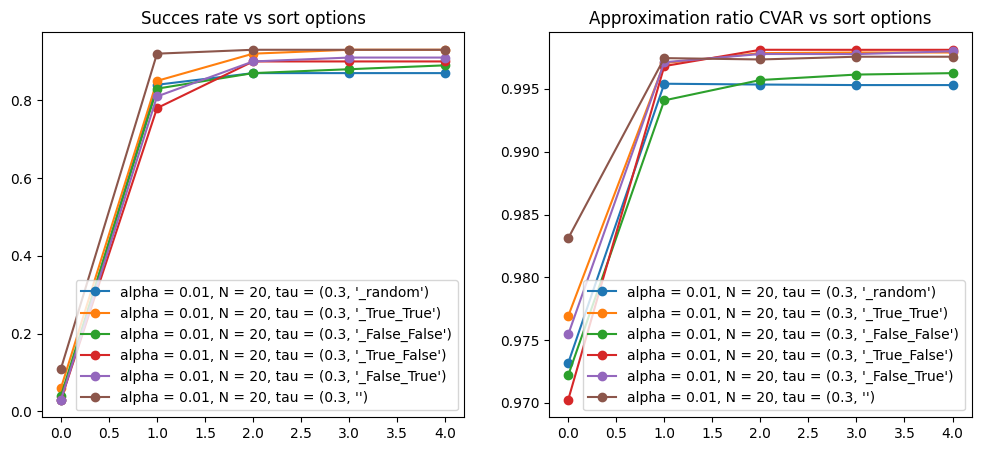

In [134]:
r_list = range(100)
tau_list = [0.3]
alpha_list = [0.01]

tot_steps = range(5)

sortoptions = ['_random', '_True_True', '_False_False', '_True_False', '_False_True', '']

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

dir_0 = './data_iter' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

dir_0_adap =  './data_iter_adap_sorting' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

alpha = 0.01 
tau = 0.3

num_variables_list = [str(num).zfill(3) for num in range(20,22, 2)] 

for num_variables in num_variables_list:



    n_qubits = int(num_variables)

    N = n_qubits

    pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
    num_pairs = len(pairs_all)
    num_params = (n_qubits + 2*num_pairs) * layer

    for taui, tau in enumerate(tau_list):
        print("\n step = ", step, "tau = ", tau, "alpha = ", alpha, "N =", N)

        dir_name =  '/num_variables_{}/params_{}_layer_{}/alpha_{}/initial_{}'\
                    .format(num_variables, num_params, layer, alpha, initialization)
        
        sr_array = np.zeros((len(sortoptions), len(tot_steps)))
        ar_array = np.zeros((len(sortoptions), len(tot_steps)))

        for step in tot_steps:
            for r in r_list:
                # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
                
                for optioni,option in enumerate(sortoptions):

                    file_dir_name = dir_name + '/r_{}'\
                                        .format(r)
                    
                    
                    if option == '':
                        filename = dir_0_adap + file_dir_name + '/tau_{}{}.pkl'.format(tau, option)
                                        
                        with open(filename, 'rb') as f:
                            data = pickle.load(f)

                    else:
                        filename = dir_0 + file_dir_name + '/tau_{}{}.pkl'.format(tau,option)
                                        
                        with open(filename, 'rb') as f:
                            data = pickle.load(f)

                    params_list = data["params_list"]
                    if len(params_list) != round(N**2):
                        print("error N, r = ", r, len(params_list))

                    steps_exp_poss_dict = data["steps_exp_poss_dict"]
                    steps_cvar_dict = data["steps_cvar_dict"]
                    final_exp_poss = steps_exp_poss_dict[f"step_{step}"]["l_1"]
                    poss_list = list(final_exp_poss.values())

                    if poss_list[0] > alpha:
                        sr_array[optioni, step] += 1/len(r_list)

                    exp_opt = list(final_exp_poss.keys())[0]
                    cvar = steps_cvar_dict[f"step_{step}"]

                    ar_array[optioni,step] += (cvar/exp_opt) / len(r_list)
        
        for optioni, option in enumerate(sortoptions):
            print("sr_array = ", sr_array)
            ax1.plot(tot_steps, sr_array[optioni], "o-", label=f"alpha = {alpha}, N = {N}, tau = {tau, option}")
            # ax1.plot(range(sortoptions), sr_array[1], "o--",label=f"alpha = {alpha}, N = {N}, adap")
            # ax1.plot(tot_steps, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

            ax2.plot(tot_steps, ar_array[optioni], "o-", label=f"alpha = {alpha}, N = {N}, tau = {tau, option}")
            # ax2.plot(range(sortoptions), ar_array[1], "o-", label=f"alpha = {alpha}, N = {N}, adap")

            ax1.set_title('Succes rate vs sort options')
            ax2.set_title('Approximation ratio CVAR vs sort options')

            ax1.legend()
            print("ar_array = ", ar_array)

plt.legend()
# plt.xlabel("iterations")
# plt.ylabel("success rate")
plt.show()


 step =  4 tau =  0.3 alpha =  0.01 N = 20
sr_array =  [[0.87 0.93 0.89 0.9  0.91 0.93]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]]
ar_array =  [[0.99530628 0.99790008 0.99625651 0.99811328 0.99799523 0.99756299]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]

 step =  4 tau =  0.6 alpha =  0.01 N = 20
sr_array =  [[0.7  0.7  0.59 0.68 0.7  0.8 ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]]
ar_array =  [[0.9845846  0.98484353 0.97981234 0.9812404  0.98508647 0.99229514]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]


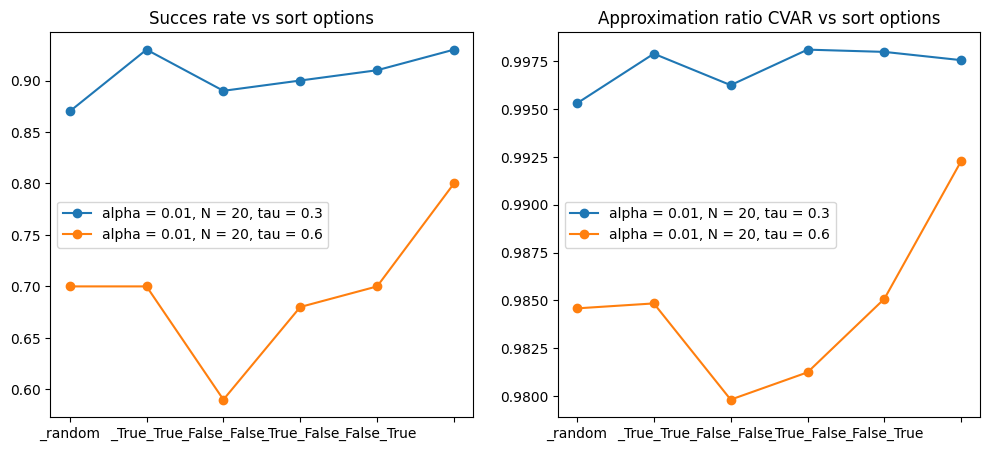

In [107]:
r_list = range(100)
tau_list = [0.3, 0.6]
alpha_list = [0.01]

tot_steps = range(5)

sortoptions = ['_random', '_True_True', '_False_False', '_True_False', '_False_True', '']

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

dir_0 = './data_iter' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

dir_0_adap =  './data_iter_adap_sorting' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

alpha = 0.01 
tau = 0.3

num_variables_list = [str(num).zfill(3) for num in range(20,22, 2)] 

for num_variables in num_variables_list:



    n_qubits = int(num_variables)

    N = n_qubits

    pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
    num_pairs = len(pairs_all)
    num_params = (n_qubits + 2*num_pairs) * layer

    for taui, tau in enumerate(tau_list):
        print("\n step = ", step, "tau = ", tau, "alpha = ", alpha, "N =", N)

        sr_array = np.zeros((len(num_opt_list), len(sortoptions)))
        ar_array = np.zeros((len(num_opt_list), len(sortoptions)))

        dir_name =  '/num_variables_{}/params_{}_layer_{}/alpha_{}/initial_{}'\
                    .format(num_variables, num_params, layer, alpha, initialization)
        
        for r in r_list:
            # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
            
            for optioni,option in enumerate(sortoptions):
                file_dir_name = dir_name + '/r_{}'\
                                    .format(r)
                
                
                if option == '':
                    filename = dir_0_adap + file_dir_name + '/tau_{}{}.pkl'.format(tau, option)
                                    
                    with open(filename, 'rb') as f:
                        data = pickle.load(f)

                else:
                    filename = dir_0 + file_dir_name + '/tau_{}{}.pkl'.format(tau,option)
                                    
                    with open(filename, 'rb') as f:
                        data = pickle.load(f)

                params_list = data["params_list"]
                if len(params_list) != round(N**2):
                    print("error N, r = ", r, len(params_list))


                steps_exp_poss_dict = data["steps_exp_poss_dict"]
                steps_cvar_dict = data["steps_cvar_dict"]
                final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
                poss_list = list(final_exp_poss.values())

                if poss_list[0] > alpha:
                    sr_array[0, optioni] += 1/len(r_list)

                exp_opt = list(final_exp_poss.keys())[0]
                cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]

                ar_array[0,optioni] += (cvar/exp_opt) / len(r_list)
        
        print("sr_array = ", sr_array)
        ax1.plot(sortoptions, sr_array[0], "o-", label=f"alpha = {alpha}, N = {N}, tau = {tau}")
        # ax1.plot(range(sortoptions), sr_array[1], "o--",label=f"alpha = {alpha}, N = {N}, adap")
        # ax1.plot(tot_steps, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

        ax2.plot(sortoptions, ar_array[0], "o-", label=f"alpha = {alpha}, N = {N}, tau = {tau}")
        # ax2.plot(range(sortoptions), ar_array[1], "o-", label=f"alpha = {alpha}, N = {N}, adap")

        ax1.set_title('Succes rate vs sort options')
        ax2.set_title('Approximation ratio CVAR vs sort options')

        ax1.legend()
        print("ar_array = ", ar_array)

plt.legend()
# plt.xlabel("iterations")
# plt.ylabel("success rate")
plt.show()


 step =  4 tau =  0.3 alpha =  0.01 N = 16
sr_array =  [[0.98 0.97 0.97 0.98 0.97 0.99]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]]
ar_array =  [[0.99971794 0.9995134  0.99967675 0.9997247  0.99935139 0.99985202]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]

 step =  4 tau =  0.3 alpha =  0.01 N = 18
sr_array =  [[0.96 0.94 0.94 0.93 0.93 0.96]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]]
ar_array =  [[0.99971446 0.99788095 0.99915737 0.99882904 0.99831035 0.99938582]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]

 step =  4 tau =  0.3 alpha =  0.01 N = 20
sr_array =  [[0.87 0.93 0.89 0.9  0.91 0.93]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]]
ar_array =  [[0.99530628 0.99790008 0.99625651 0.99811328 0.99799523 0.99756299]
 [0.       

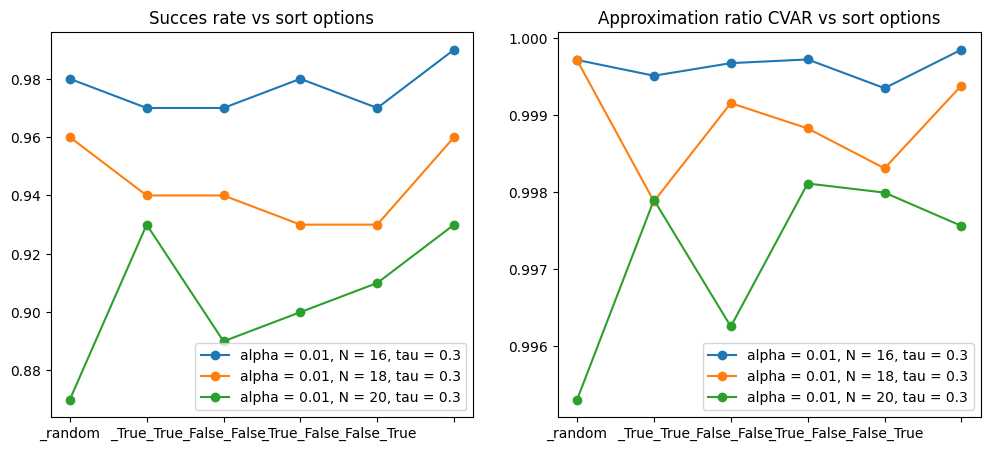

In [135]:
r_list = range(100)
tau_list = [0.3]
alpha_list = [0.01]

tot_steps = range(5)

sortoptions = ['_random', '_True_True', '_False_False', '_True_False', '_False_True', '']

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

dir_0 = './data_iter' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

dir_0_adap =  './data_iter_adap_sorting' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

alpha = 0.01 
tau = 0.3

num_variables_list = [str(num).zfill(3) for num in range(16,22, 2)] 

for num_variables in num_variables_list:



    n_qubits = int(num_variables)

    N = n_qubits

    pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
    num_pairs = len(pairs_all)
    num_params = (n_qubits + 2*num_pairs) * layer

    for taui, tau in enumerate(tau_list):
        print("\n step = ", step, "tau = ", tau, "alpha = ", alpha, "N =", N)

        sr_array = np.zeros((len(num_opt_list), len(sortoptions)))
        ar_array = np.zeros((len(num_opt_list), len(sortoptions)))

        dir_name =  '/num_variables_{}/params_{}_layer_{}/alpha_{}/initial_{}'\
                    .format(num_variables, num_params, layer, alpha, initialization)
        
        for r in r_list:
            # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
            
            for optioni,option in enumerate(sortoptions):
                file_dir_name = dir_name + '/r_{}'\
                                    .format(r)
                
                
                if option == '':
                    filename = dir_0_adap + file_dir_name + '/tau_{}{}.pkl'.format(tau, option)
                                    
                    with open(filename, 'rb') as f:
                        data = pickle.load(f)

                else:
                    filename = dir_0 + file_dir_name + '/tau_{}{}.pkl'.format(tau,option)
                                    
                    with open(filename, 'rb') as f:
                        data = pickle.load(f)

                params_list = data["params_list"]
                if len(params_list) != round(N**2):
                    print("error N, r = ", r, len(params_list))


                steps_exp_poss_dict = data["steps_exp_poss_dict"]
                steps_cvar_dict = data["steps_cvar_dict"]
                final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
                poss_list = list(final_exp_poss.values())

                if poss_list[0] > alpha:
                    sr_array[0, optioni] += 1/len(r_list)

                exp_opt = list(final_exp_poss.keys())[0]
                cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]

                ar_array[0,optioni] += (cvar/exp_opt) / len(r_list)
        
        print("sr_array = ", sr_array)
        ax1.plot(sortoptions, sr_array[0], "o-", label=f"alpha = {alpha}, N = {N}, tau = {tau}")
        # ax1.plot(range(sortoptions), sr_array[1], "o--",label=f"alpha = {alpha}, N = {N}, adap")
        # ax1.plot(tot_steps, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

        ax2.plot(sortoptions, ar_array[0], "o-", label=f"alpha = {alpha}, N = {N}, tau = {tau}")
        # ax2.plot(range(sortoptions), ar_array[1], "o-", label=f"alpha = {alpha}, N = {N}, adap")

        ax1.set_title('Succes rate vs sort options')
        ax2.set_title('Approximation ratio CVAR vs sort options')

        ax1.legend()
        print("ar_array = ", ar_array)

plt.legend()
# plt.xlabel("iterations")
# plt.ylabel("success rate")
plt.show()

STOP HERE!!!!!!!!!!!!!!!!!!!!!


tau =  0.05 alpha =  0.01

tau =  0.1 alpha =  0.01

tau =  0.2 alpha =  0.01

tau =  0.4 alpha =  0.01

tau =  0.6 alpha =  0.01
sr_array =  [[0.78 0.88 0.89 0.83 0.7 ]
 [0.89 0.94 0.96 0.88 0.78]
 [0.92 0.97 0.99 0.91 0.82]]
ar_array =  [0.99113628 0.99661714 0.99751693 0.99398891 0.98458413]


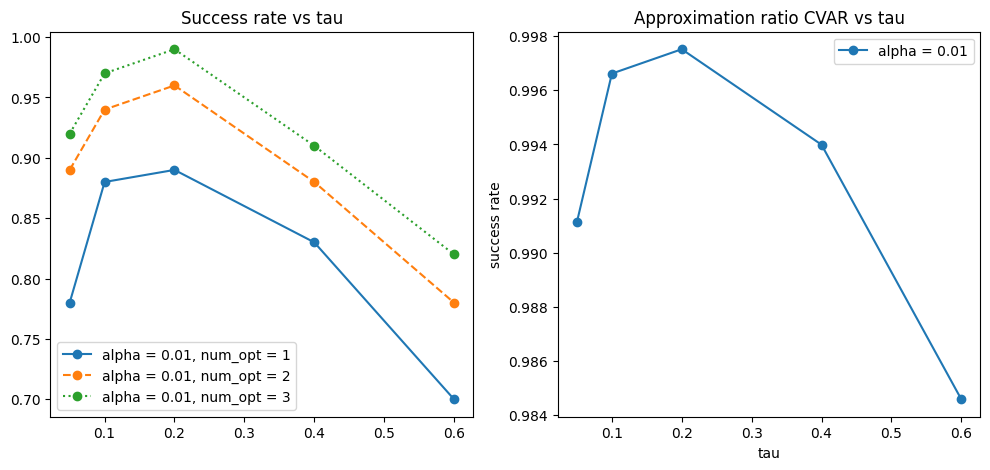

In [69]:
N=20
r_list = range(100)
tau_list = [0.05, 0.1, 0.2, 0.4, 0.6]
alpha_list = [0.01]

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
for alpha in alpha_list:
    sr_array = np.zeros((len(num_opt_list), len(tau_list)))
    ar_array = np.zeros(len(tau_list))
    for taui, tau in enumerate(tau_list):
        print("\ntau = ", tau, "alpha = ", alpha)
        for r in r_list:
            filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
            with open(filename, 'rb') as f:
                data = pickle.load(f)
            params_list = data["params_list"]
            if len(params_list) != round(N**2):
                print("error N, r = ", r, len(params_list))
            steps_exp_poss_dict = data["steps_exp_poss_dict"]
            steps_cvar_dict = data["steps_cvar_dict"]
            
            final_exp_poss = steps_exp_poss_dict["step_5"]["l_1"]
            poss_list = list(final_exp_poss.values())
            if poss_list[0] > alpha:
                sr_array[0, taui] += 1/len(r_list)
            if sum(poss_list[:2]) > alpha:
                sr_array[1, taui] += 1/len(r_list)
            if sum(poss_list[:3]) > alpha:
                sr_array[2, taui] += 1/len(r_list)

            exp_opt = list(final_exp_poss.keys())[0]
            cvar = steps_cvar_dict["step_9"]
            ar_array[taui] += (cvar/exp_opt) / len(r_list)

    print("sr_array = ", sr_array)
    ax1.plot(tau_list, sr_array[0], "o-", label=f"alpha = {alpha}, num_opt = 1")
    ax1.plot(tau_list, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
    ax1.plot(tau_list, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

    ax2.plot(tau_list, ar_array, "o-", label=f"alpha = {alpha}")
    print("ar_array = ", ar_array)

    ax1.set_title('Success rate vs tau')
    ax2.set_title('Approximation ratio CVAR vs tau')

    ax1.legend()
plt.legend()
plt.xlabel("tau")
plt.ylabel("success rate")
plt.show()



In [45]:
steps_exp_poss_dict.keys()

dict_keys(['step_0', 'step_1', 'step_2', 'step_3', 'step_4', 'step_5', 'step_6', 'step_7', 'step_8', 'step_9'])


 step =  0 tau =  0.2 alpha =  0.01

 step =  1 tau =  0.2 alpha =  0.01

 step =  2 tau =  0.2 alpha =  0.01

 step =  3 tau =  0.2 alpha =  0.01

 step =  4 tau =  0.2 alpha =  0.01

 step =  5 tau =  0.2 alpha =  0.01

 step =  6 tau =  0.2 alpha =  0.01

 step =  7 tau =  0.2 alpha =  0.01

 step =  8 tau =  0.2 alpha =  0.01

 step =  9 tau =  0.2 alpha =  0.01
sr_array =  [[0.   0.82 0.88 0.89 0.89 0.89 0.89 0.89 0.89 0.89]
 [0.   0.89 0.92 0.95 0.95 0.96 0.96 0.96 0.96 0.96]
 [0.   0.94 0.97 0.99 0.99 0.99 0.99 0.99 0.99 0.99]]
ar_array =  [0.95654325 0.99600428 0.99727966 0.99754692 0.99749912 0.99751693
 0.99751693 0.99751693 0.99751693 0.99751693]


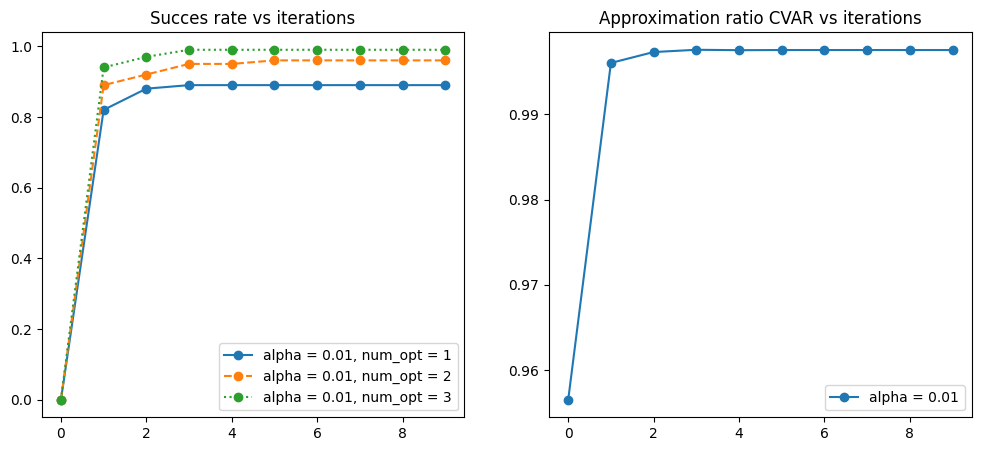

In [70]:
N=20
r_list = range(100)
tau_list = [0.6]
alpha_list = [0.01]

tot_steps = range(10)

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

sr_array = np.zeros((len(num_opt_list), len(tot_steps)))
ar_array = np.zeros(len(tot_steps))

alpha = 0.01 
tau = 0.2

for step in tot_steps:
    print("\n step = ", step, "tau = ", tau, "alpha = ", alpha)
    for r in r_list:
        filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        params_list = data["params_list"]
        if len(params_list) != round(N**2):
            print("error N, r = ", r, len(params_list))
        steps_exp_poss_dict = data["steps_exp_poss_dict"]
        steps_cvar_dict = data["steps_cvar_dict"]
        
        final_exp_poss = steps_exp_poss_dict[f"step_{step}"]["l_1"]
        # print(len( steps_exp_poss_dict[f"step_{step}"]["l_1"]))
        # print( steps_exp_poss_dict[f"step_{step}"]["l_1"])
        poss_list = list(final_exp_poss.values())
        # print(len(poss_list))
        # print(poss_list)
        if poss_list[0] > alpha:
            sr_array[0, step] += 1/len(r_list)
        if sum(poss_list[:2]) > alpha:
            sr_array[1, step] += 1/len(r_list)
        if sum(poss_list[:3]) > alpha:
            sr_array[2, step] += 1/len(r_list)

        exp_opt = list(final_exp_poss.keys())[0]
        # print(exp_opt)
        cvar = steps_cvar_dict[f"step_{step}"]
        ar_array[step] += (cvar/exp_opt) / len(r_list)

print("sr_array = ", sr_array)
ax1.plot(tot_steps, sr_array[0], "o-", label=f"alpha = {alpha}, num_opt = 1")
ax1.plot(tot_steps, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
ax1.plot(tot_steps, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

ax2.plot(tot_steps, ar_array, "o-", label=f"alpha = {alpha}")

ax1.set_title('Succes rate vs iterations')
ax2.set_title('Approximation ratio CVAR vs iterations')

ax1.legend()
print("ar_array = ", ar_array)
plt.legend()
# plt.xlabel("iterations")
# plt.ylabel("success rate")
plt.show()


 step =  0 tau =  0.05 alpha =  0.01

 step =  1 tau =  0.05 alpha =  0.01

 step =  2 tau =  0.05 alpha =  0.01

 step =  3 tau =  0.05 alpha =  0.01

 step =  4 tau =  0.05 alpha =  0.01

 step =  5 tau =  0.05 alpha =  0.01

 step =  6 tau =  0.05 alpha =  0.01

 step =  7 tau =  0.05 alpha =  0.01

 step =  8 tau =  0.05 alpha =  0.01

 step =  9 tau =  0.05 alpha =  0.01
sr_array =  [[0.   0.01 0.58 0.75 0.78 0.78 0.78 0.78 0.78 0.78]
 [0.   0.07 0.69 0.87 0.88 0.89 0.89 0.89 0.89 0.89]
 [0.   0.09 0.76 0.9  0.91 0.92 0.92 0.92 0.92 0.92]]
ar_array =  [0.75121232 0.91097421 0.98177961 0.98982886 0.9904619  0.99058298
 0.99113628 0.99113628 0.99113628 0.99113628]

 step =  0 tau =  0.1 alpha =  0.01

 step =  1 tau =  0.1 alpha =  0.01

 step =  2 tau =  0.1 alpha =  0.01

 step =  3 tau =  0.1 alpha =  0.01

 step =  4 tau =  0.1 alpha =  0.01

 step =  5 tau =  0.1 alpha =  0.01

 step =  6 tau =  0.1 alpha =  0.01

 step =  7 tau =  0.1 alpha =  0.01

 step =  8 tau =  0.1 alph

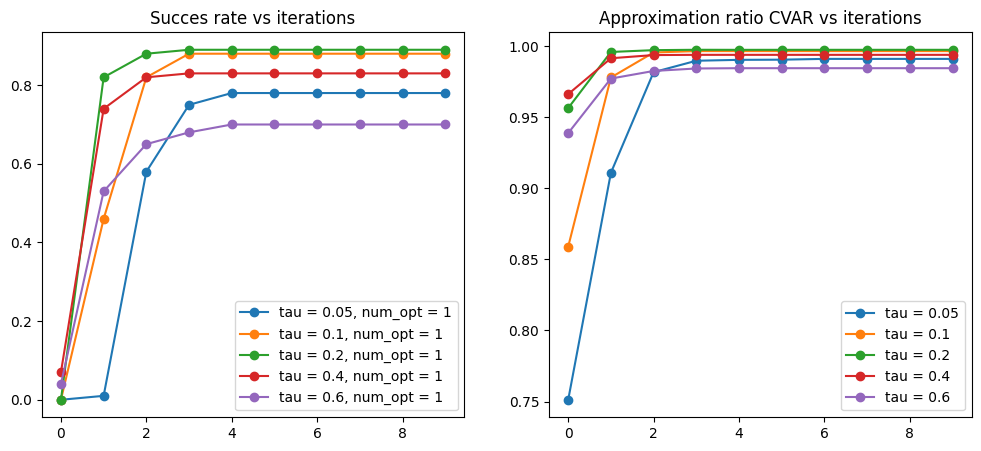

In [67]:
N=20
r_list = range(100)
tau_list = [0.05, 0.1, 0.2, 0.4, 0.6]
alpha_list = [0.01]

tot_steps = range(10)

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

alpha = 0.01 
tau = 0.6

for tau in tau_list:
    sr_array = np.zeros((len(num_opt_list), len(tot_steps)))
    ar_array = np.zeros(len(tot_steps)) 
    for step in tot_steps:
        print("\n step = ", step, "tau = ", tau, "alpha = ", alpha)
        for r in r_list:
            filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
            with open(filename, 'rb') as f:
                data = pickle.load(f)
            params_list = data["params_list"]
            if len(params_list) != round(N**2):
                print("error N, r = ", r, len(params_list))
            steps_exp_poss_dict = data["steps_exp_poss_dict"]
            steps_cvar_dict = data["steps_cvar_dict"]
            
            final_exp_poss = steps_exp_poss_dict[f"step_{step}"]["l_1"]
            # print(len( steps_exp_poss_dict[f"step_{step}"]["l_1"]))
            # print( steps_exp_poss_dict[f"step_{step}"]["l_1"])
            poss_list = list(final_exp_poss.values())
            # print(len(poss_list))
            # print(poss_list)
            if poss_list[0] > alpha:
                sr_array[0, step] += 1/len(r_list)
            if sum(poss_list[:2]) > alpha:
                sr_array[1, step] += 1/len(r_list)
            if sum(poss_list[:3]) > alpha:
                sr_array[2, step] += 1/len(r_list)

            exp_opt = list(final_exp_poss.keys())[0]
            # print(exp_opt)
            cvar = steps_cvar_dict[f"step_{step}"]
            ar_array[step] += (cvar/exp_opt) / len(r_list)

    print("sr_array = ", sr_array)
    ax1.plot(tot_steps, sr_array[0], "o-", label=f"tau = {tau}, num_opt = 1")
    # ax1.plot(tot_steps, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
    # ax1.plot(tot_steps, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

    ax2.plot(tot_steps, ar_array, "o-", label=f"tau = {tau}")

    ax1.set_title('Succes rate vs iterations')
    ax2.set_title('Approximation ratio CVAR vs iterations')

    ax1.legend()
    print("ar_array = ", ar_array)
plt.legend()
# plt.xlabel("iterations")
# plt.ylabel("success rate")
plt.show()